In [65]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import missingno
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import sqlite3

# Introduction
Battlefield 5 is a multiplayer first person shooter game developed by DICE and published by EA. It released on current generation Playstation and XBox consoles as well as PC in 2018. In this notebook, I determine whether the players can be segmented according to information about how they play the game. There are many ways one might segment the data in a rule-based fashion - according to platform, most played class, etc. Instead of doing this, I am interested in whether we can cluster players in some useful fashion according to various player metrics that are recorded and made available.

To do this, I scraped data off of [Battlefield Tracker](https://battlefieldtracker.com/). This comes with a caveat. While the game sold ar4ound 7.8 million copies, publicly available data only tracks about 1% of that. So in fact, this analysis really only tracks the top 10% of players snf dhoulf not be assumed to extend beyond that.

In [66]:
con = sqlite3.connect('bfvstats.db')
cur = con.cursor()

info = cur.execute('SELECT * FROM pragma_table_info("bfvstats")').fetchall() # column names (and other info)
query_cols = list(map(lambda x: x[1], info))[1:] # retrieve only names of columns I want to keep
query_cols = ','.join(query_cols)

df = pd.read_sql(f'SELECT {query_cols} FROM bfvstats', con)
df = df.drop(df.columns[0], axis=1)
df.head()

,platform,scorePerMinute_value,scorePerMinute_percentile,kdRatio_value,kdRatio_percentile,kills_value,kills_percentile,deaths_value,deaths_percentile,damage_value,...,Tanker_shotsFired_value,Tanker_shotsFired_percentile,Tanker_shotsHit_value,Tanker_shotsHit_percentile,Tanker_shotsAccuracy_value,Tanker_shotsAccuracy_percentile,Tanker_score_value,Tanker_score_percentile,Tanker_scorePerMinute_value,Tanker_scorePerMinute_percentile
0,psn,378.792295,71.0,2.620212,93.0,515490,99.9,196736,None,59433079,...,0,None,0,None,0.0,None,1780075,94.0,814.679634,64.0
1,psn,549.142755,96.6,5.595874,99.0,659401,99.9,117837,None,72180090,...,0,None,0,None,0.0,None,159756,69.0,420.410526,24.0
2,psn,252.147827,28.0,1.748259,79.0,423493,99.9,242237,None,51395987,...,0,None,0,None,0.0,None,84699,58.0,1693.980000,81.0
3,origin,668.252814,99.0,5.202617,98.9,938318,99.9,180355,None,107543331,...,0,None,0,None,0.0,None,9943381,99.5,748.410432,61.0
4,psn,316.174639,50.0,2.545317,93.0,444364,99.9,174581,None,51220628,...,0,None,0,None,0.0,None,35013,41.0,2059.588235,84.0


There are many features. Given I simply dumped data from an API into a csv file, and I suspect at least some features only took one unique value, I check to see if that is the case. Features taking only one value, whether NaN values or other values, are useless when applying machine learning methods, since they do not distinguish any sample from any other sample. This does not make such features useless per se (ex. suppose you learned everyone on Earth's favorite color was red; this would be very interesting if not useful for distinguishing between people).

In [67]:
null_features = []
for col in df.columns:
    if len(df[col].unique()) == 1:
        null_features.append(col)
num_null_features = len(null_features)
print(f'There are {num_null_features} features with only one unique value')

There are 104 features with only one unique value


This is a lot of features. I expect many of them are percentiles, as eyeballing the JSON, it appeared not all of these features actually took non-None values. I check this assumption below.

In [68]:
null_percentile_features = []
null_other_features = []
for feature in null_features:
    if 'percentile' in feature:
        null_percentile_features.append(feature)
    else:
        null_other_features.append(feature)
num_percentile_null_features = len(null_percentile_features)
print(f'Of features taking only one unique value, {num_percentile_null_features} are percentiles.')
print(f'The other features taking only one unique value are below:')
null_other_features

Of features taking only one unique value, 93 are percentiles.
The other features taking only one unique value are below:


['rankScore_value',
 'Pilot_deaths_value',
 'Pilot_kdRatio_value',
 'Pilot_shotsFired_value',
 'Pilot_shotsHit_value',
 'Pilot_shotsAccuracy_value',
 'Tanker_deaths_value',
 'Tanker_kdRatio_value',
 'Tanker_shotsFired_value',
 'Tanker_shotsHit_value',
 'Tanker_shotsAccuracy_value']

Below I check to see if these features have unique values that are non-NaN and greater than zero, a value of zero being unreasonable for all of thousands of players.

In [69]:
non_null_count = 0
for feat in null_other_features + null_percentile_features:
    
    if  df[feat].unique()[0] != 0 and (not df[feat].isna().all()):
        print(f'{feat} takes a non-NaN value')
        non_null_count += 1
if non_null_count == 0:
    print('All of the scores take either NaN values or 0 as their only value.')

All of the scores take either NaN values or 0 as their only value.


We can discard the features discussed above as useless. While taking only a single value does not make a feature useless to any sort of analysis, the values these features take must mean that the features simply refer to metrics that were not stored. This is moreso obvious for anything taking a NaN value, but it simply could not be the case that every player on the leaderboard has an accuracy of zero with tanks - you could undoubtedly look up some of these players on Youtube to confirm that.

In [70]:
df.drop(null_other_features + null_percentile_features, axis=1, inplace=True)

In [71]:
df.head()

,platform,scorePerMinute_value,scorePerMinute_percentile,kdRatio_value,kdRatio_percentile,kills_value,kills_percentile,deaths_value,damage_value,damage_percentile,...,Support_score_percentile,Support_scorePerMinute_value,Support_scorePerMinute_percentile,Tanker_kills_value,Tanker_killsPerMinute_value,Tanker_timePlayed_value,Tanker_score_value,Tanker_score_percentile,Tanker_scorePerMinute_value,Tanker_scorePerMinute_percentile
0,psn,378.792295,71.0,2.620212,93.0,515490,99.9,196736,59433079,99.9,...,99.3,289.356158,40.0,4398,2.012815,131130,1780075,94.0,814.679634,64.0
1,psn,549.142755,96.6,5.595874,99.0,659401,99.9,117837,72180090,99.9,...,99.9,564.771881,96.3,415,1.092105,22805,159756,69.0,420.410526,24.0
2,psn,252.147827,28.0,1.748259,79.0,423493,99.9,242237,51395987,99.9,...,99.8,241.141921,25.0,170,3.400000,3025,84699,58.0,1693.980000,81.0
3,origin,668.252814,99.0,5.202617,98.9,938318,99.9,180355,107543331,99.9,...,99.9,687.984176,98.6,36641,2.757865,797160,9943381,99.5,748.410432,61.0
4,psn,316.174639,50.0,2.545317,93.0,444364,99.9,174581,51220628,99.9,...,99.7,330.559824,54.0,22,1.294118,1040,35013,41.0,2059.588235,84.0


# Feature Engineering

## Convert Time Played Features to Hours
The time played features are given in seconds. I would prefer to have these in hours to make them easier to read.

In [72]:
for feature in df.columns:
    if 'timeplayed' in feature.lower():
        df[feature] /= 3600

## Scaling Features by Time Played
A number of features here are presented in raw values like damage_value, which gives the amount of damage a player has done while playing the game. This value, however, will be influenced by the amount of time a player has played the game. A more interpretable measure would be the amount of damage a player has done per unit of time played. To be consistent with features already in the dataset, I will scale time independent features on a per minute basis. I will not scale features that already have some per minute equivalent, like kills per minute or shot accuracy.

Note that this should not remove time dependence entirely. The average player who has only played 5 hours is likely to have fewer kills per minute than someone with 500 hours played because they have less familiarity with the game, for example.

In [73]:
features_to_scale = ['deaths_value', 'assists_value', 'assistsAsKills_value', 'dogtagsTaken_value', 'avengerKills_value', 'saviorKills_value', 'headshots_value', \
    'suppressionAssists_value', 'heals_value', 'revives_value', 'revivesRecieved_value', 'resupplies_value', 'repairs_value', 'aceSquad_value', 'squadSpawns_value', 'squadWipes_value', 'ordersCompleted_value',\
        'scoreMedic_value', 'scoreAssault_value', 'scoreSupport_value', 'scoreRecon_value', 'scoreAir_value', 'scoreLand_value', 'scoreTanks_value', 'scoreTransports_value', 'scoreRound_value',\
            'scoreGeneral_value', 'scoreCombat_value', 'scoreDefensive_value', 'scoreObjective_value', 'scoreBonus_value', 'scoreSquad_value', 'scoreAward_value']

for feature in features_to_scale:
    df[f'{feature}_PerMinute'] = df[feature]/(df['timePlayed_value'] * 60)

I then drop the untransformed features.

In [74]:
#df.drop(features_to_scale, axis=1, inplace=True)

# Exploratory Data Analysis
There are enough features that plotting all of their distributions at once is a bit confusing. So first, I break the features into categories, one for each class, vehicle and a catch all category for the rest. Then I plot each category separately.

In [75]:
medic_features = [ ]
assault_features = []
support_features = []
recon_features = []
ground_vehicle_features = []
plane_features = []
general_features = []

for feature in df.columns:
    if 'medic' in feature.lower():
        medic_features.append(feature)
    elif 'assault' in feature.lower():
        assault_features.append(feature)
    elif 'support' in feature.lower():
        support_features.append(feature)
    elif 'recon' in feature.lower():
        recon_features.append(feature)
    elif 'tank' in feature.lower() or 'transport' in feature.lower():
        ground_vehicle_features.append(feature)
    elif 'air' in feature.lower() or 'plane' in feature.lower() or 'pilot' in feature.lower():
        plane_features.append(feature)
    else:
        general_features.append(feature)


## General Features

In [76]:
df.head()

,platform,scorePerMinute_value,scorePerMinute_percentile,kdRatio_value,kdRatio_percentile,kills_value,kills_percentile,deaths_value,damage_value,damage_percentile,...,scoreTanks_value_PerMinute,scoreTransports_value_PerMinute,scoreRound_value_PerMinute,scoreGeneral_value_PerMinute,scoreCombat_value_PerMinute,scoreDefensive_value_PerMinute,scoreObjective_value_PerMinute,scoreBonus_value_PerMinute,scoreSquad_value_PerMinute,scoreAward_value_PerMinute
0,psn,378.792295,71.0,2.620212,93.0,515490,99.9,196736,59433079,99.9,...,3.933417,0.488662,378.792216,185.905511,208.068007,115.979804,57.360147,68.652783,79.885162,23.921580
1,psn,549.142755,96.6,5.595874,99.0,659401,99.9,117837,72180090,99.9,...,0.616233,0.081157,549.142154,326.561137,415.782286,122.248366,10.370143,97.195151,84.324912,31.219794
2,psn,252.147827,28.0,1.748259,79.0,423493,99.9,242237,51395987,99.9,...,0.180427,0.038220,252.147772,193.602270,170.331232,66.703670,15.056590,39.371603,43.850773,25.188566
3,origin,668.252814,99.0,5.202617,98.9,938318,99.9,180355,107543331,99.9,...,25.702863,0.519278,668.252520,196.895422,374.071080,120.663579,180.392805,126.753313,70.364644,30.932746
4,psn,316.174639,50.0,2.545317,93.0,444364,99.9,174581,51220628,99.9,...,0.055098,0.050619,316.173918,227.042953,205.133785,72.112125,40.898231,55.193586,59.781133,27.173190


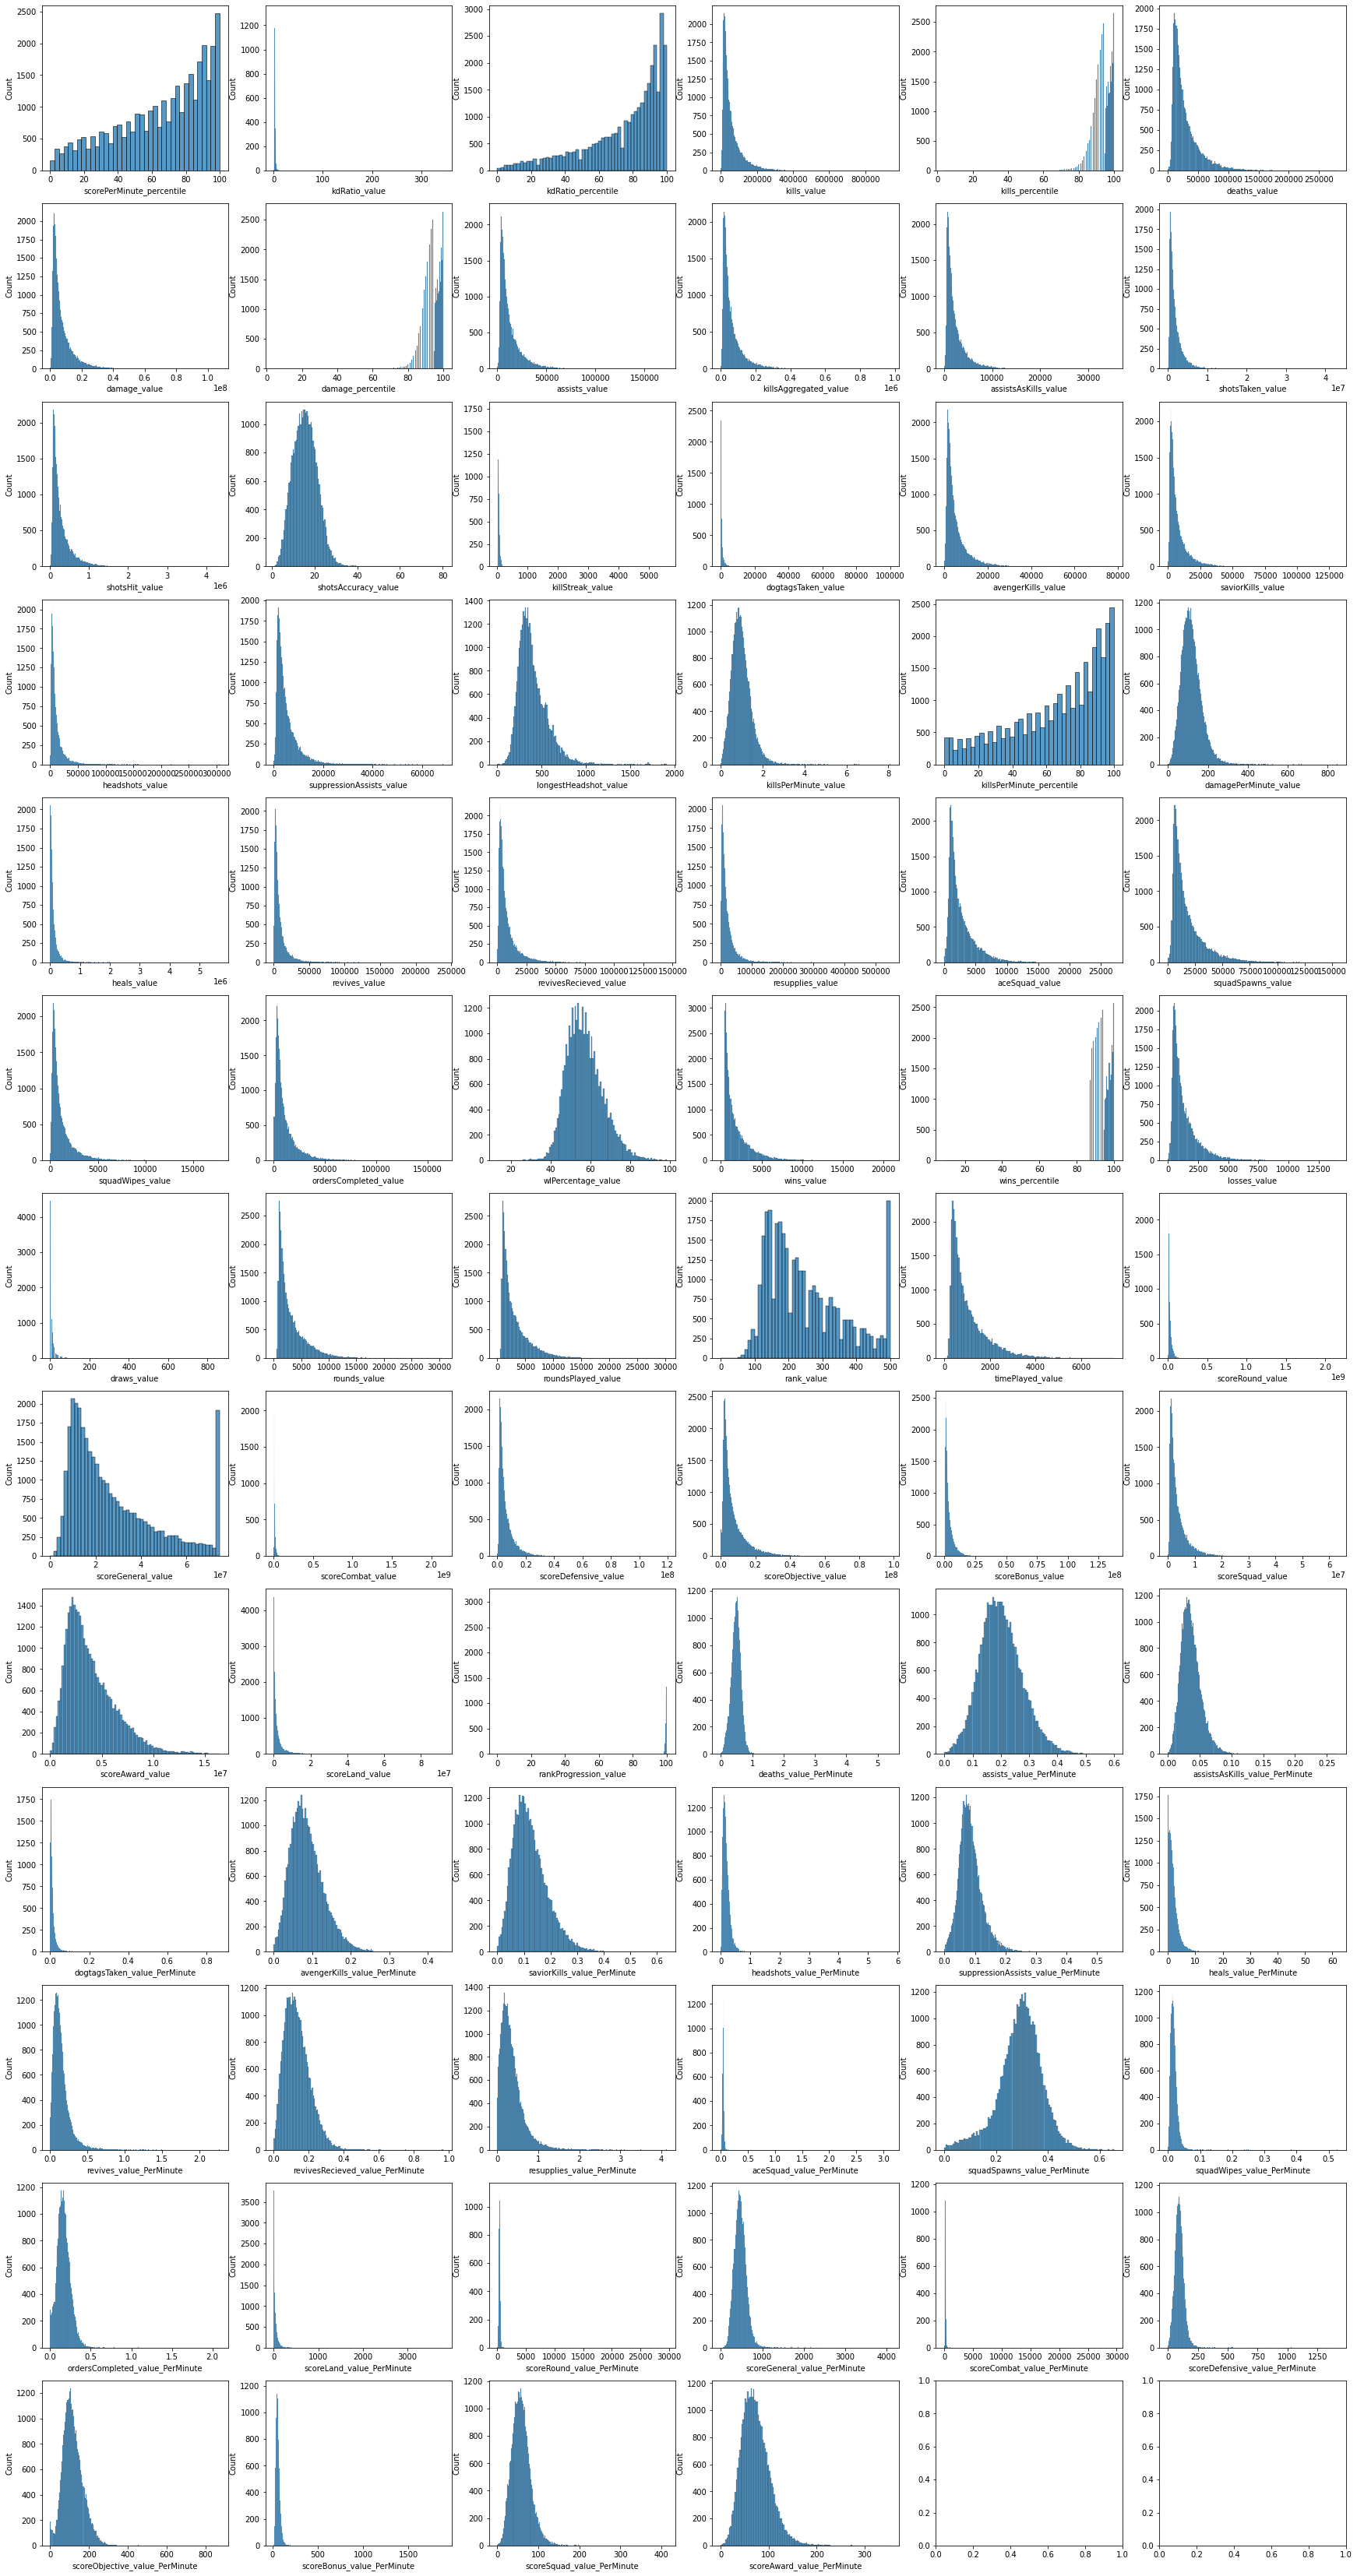

In [77]:
fig, axes = plt.subplots(13, 6, figsize=(30, 60))
for ax, feat in zip(np.ravel(axes), general_features[2:]):
    sns.histplot(data=df, x=feat, ax=ax)

## Medic Features
Note for the medic and all other classes, we have score features scaled by two different time features. Features named with the form like "Medic_scorePerMinute_value" is the score for the medic scaled by time spent playing the class. Features named with the form "scoreMedic_value_PerMinute" are scaled by total time spent playing the game.

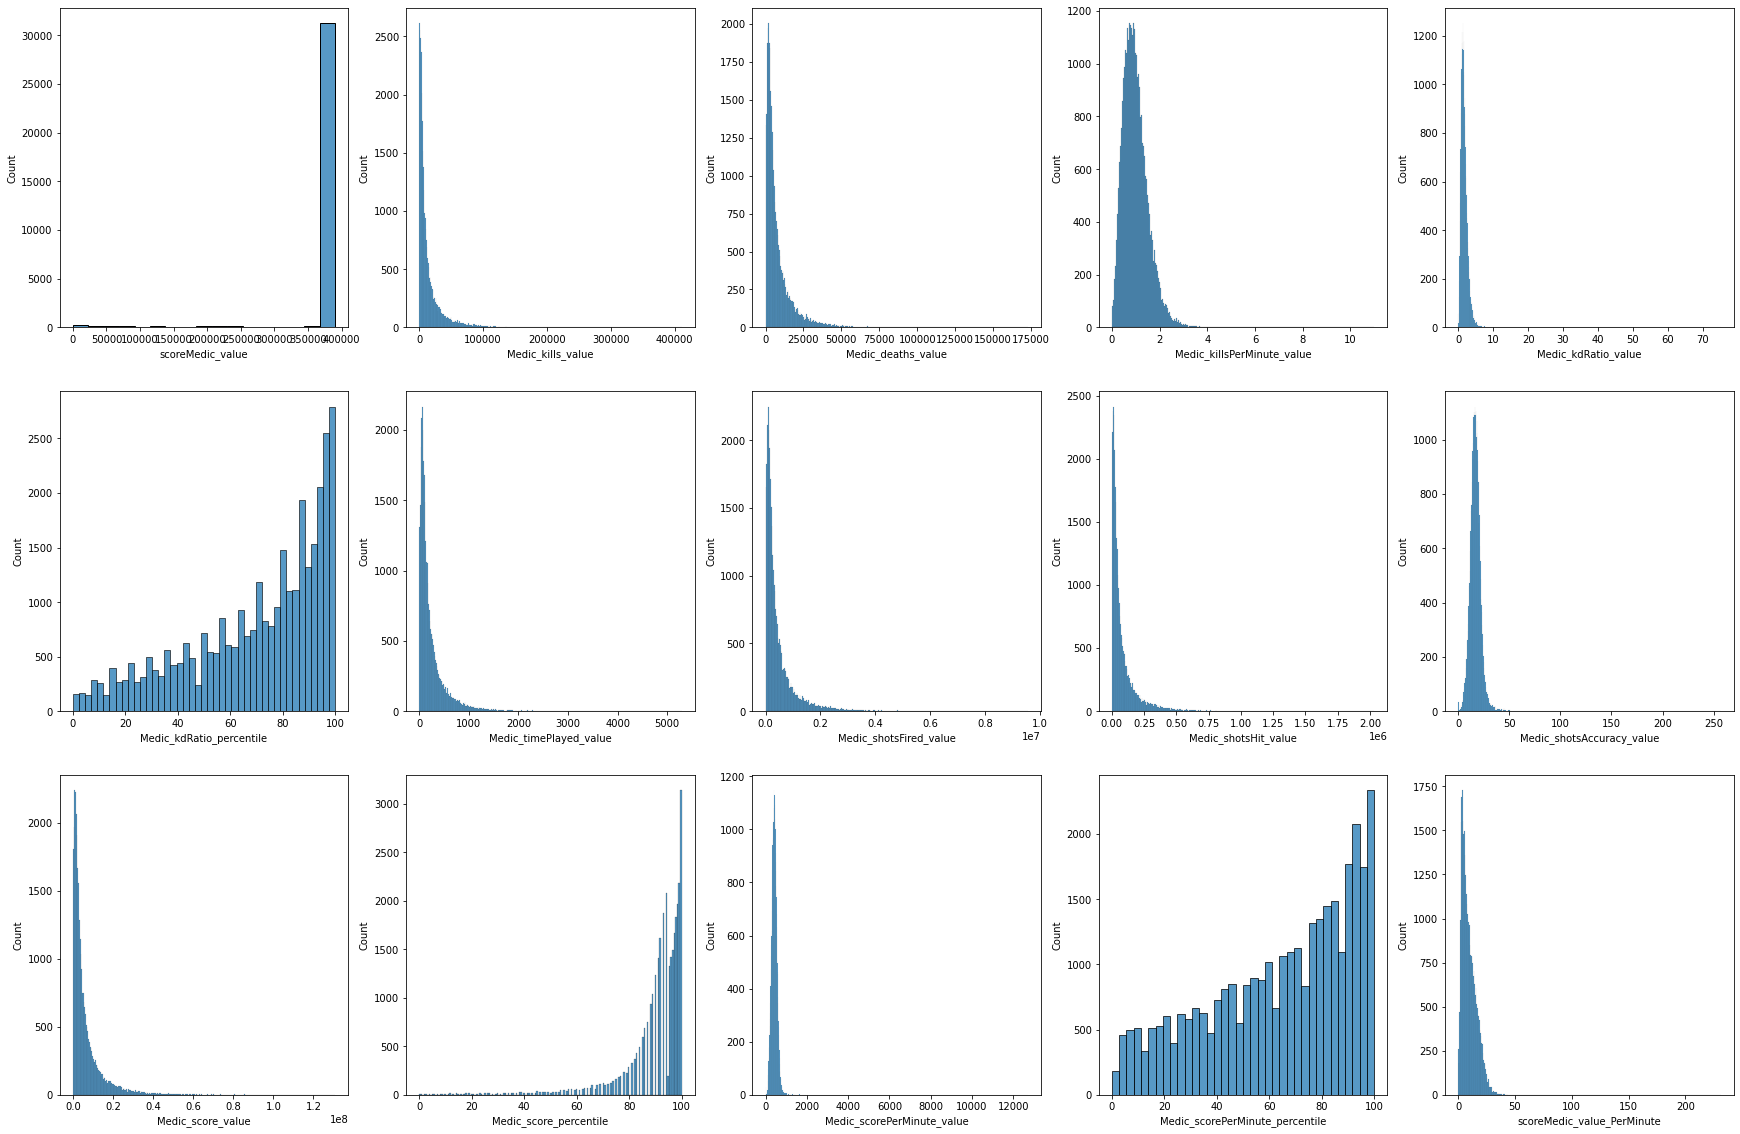

In [78]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
for ax, feat in zip(np.ravel(axes), medic_features):
    sns.histplot(data=df, x=feat, ax=ax)

## Assault Features

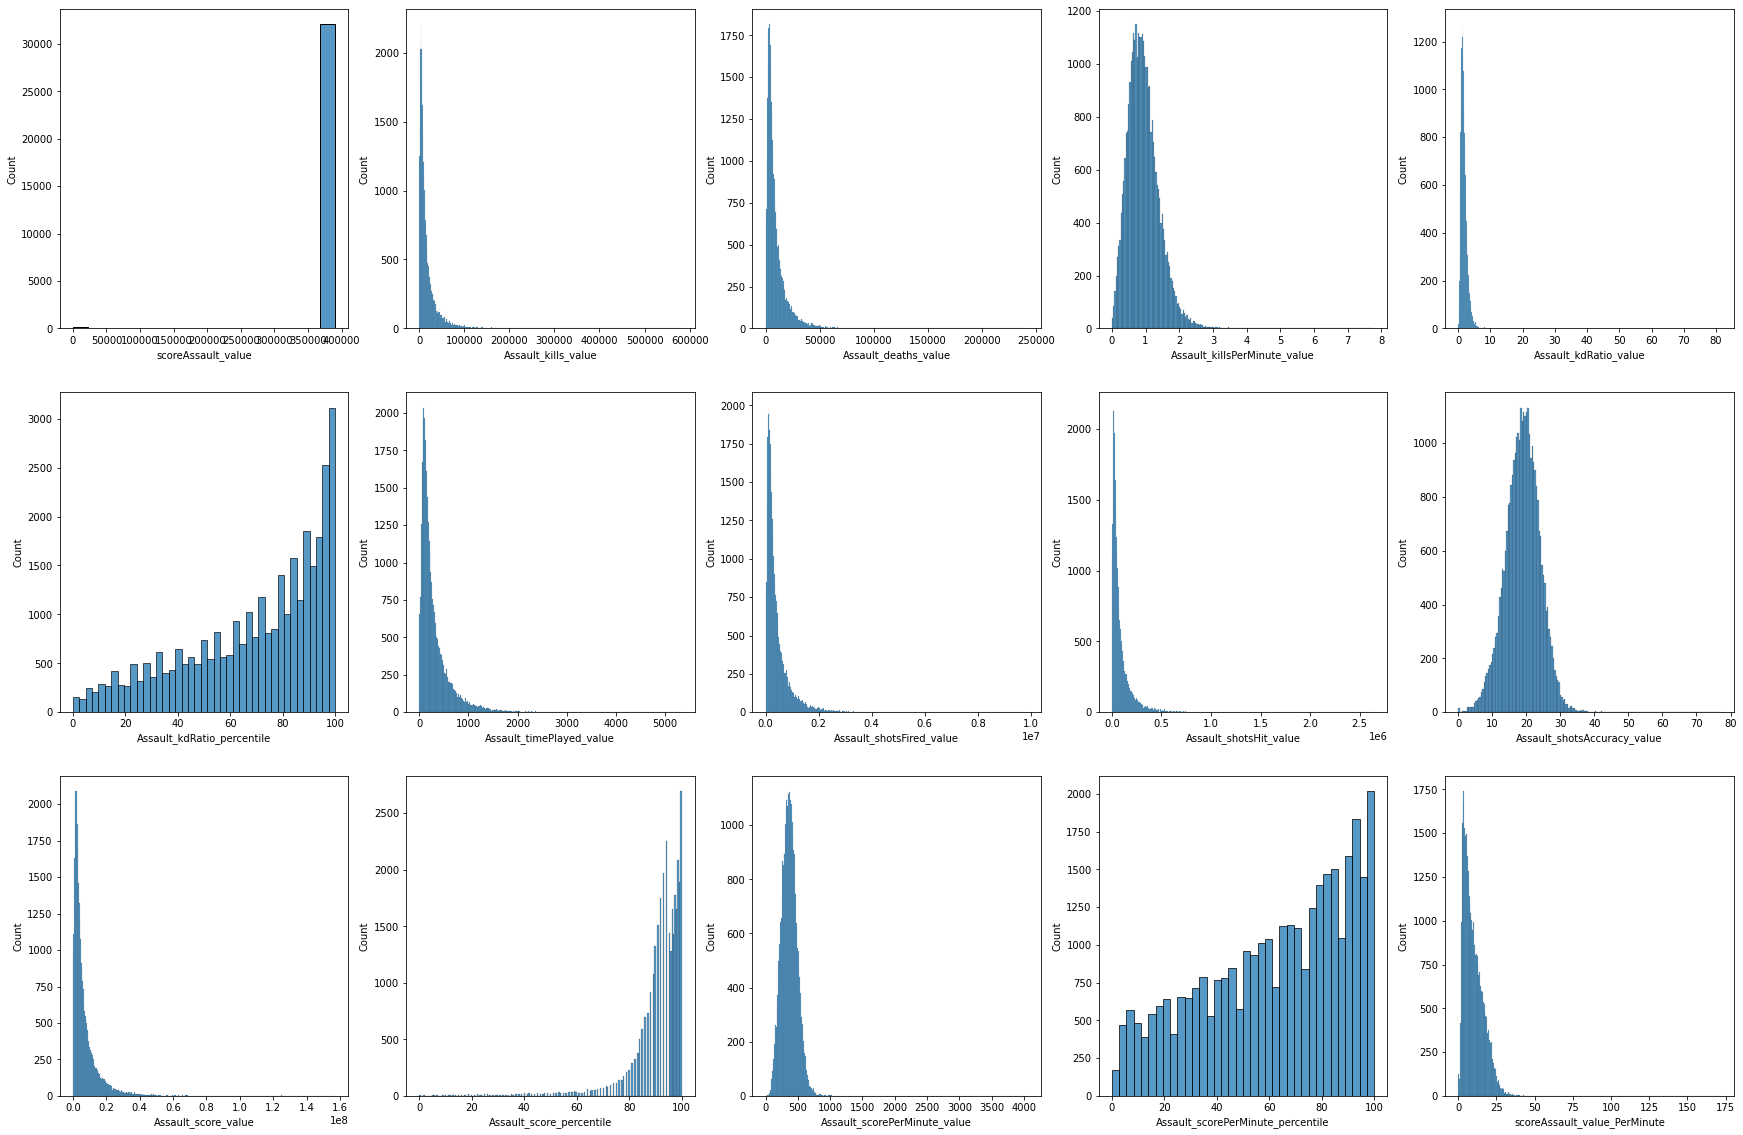

In [79]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
for ax, feat in zip(np.ravel(axes), assault_features):
    sns.histplot(data=df, x=feat, ax=ax)

## Support Features

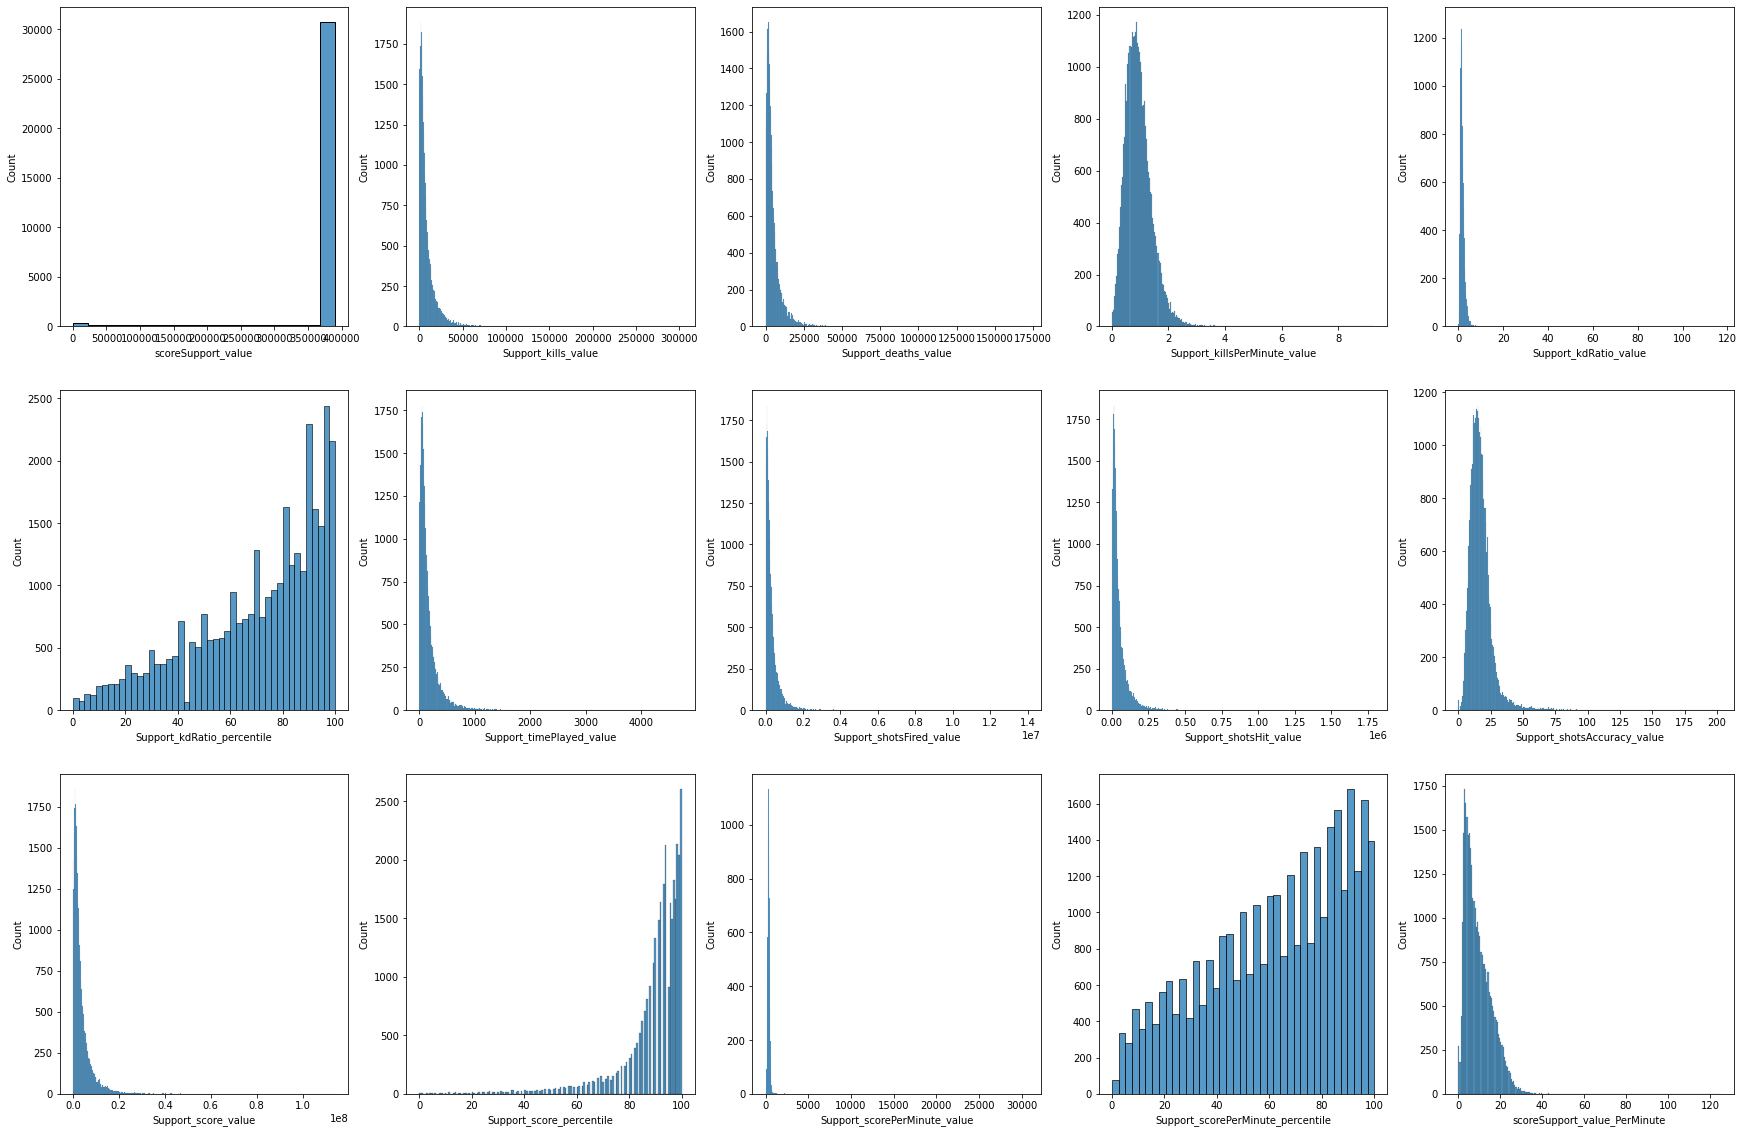

In [80]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
for ax, feat in zip(np.ravel(axes), support_features):
    sns.histplot(data=df, x=feat, ax=ax)

## Recon Features

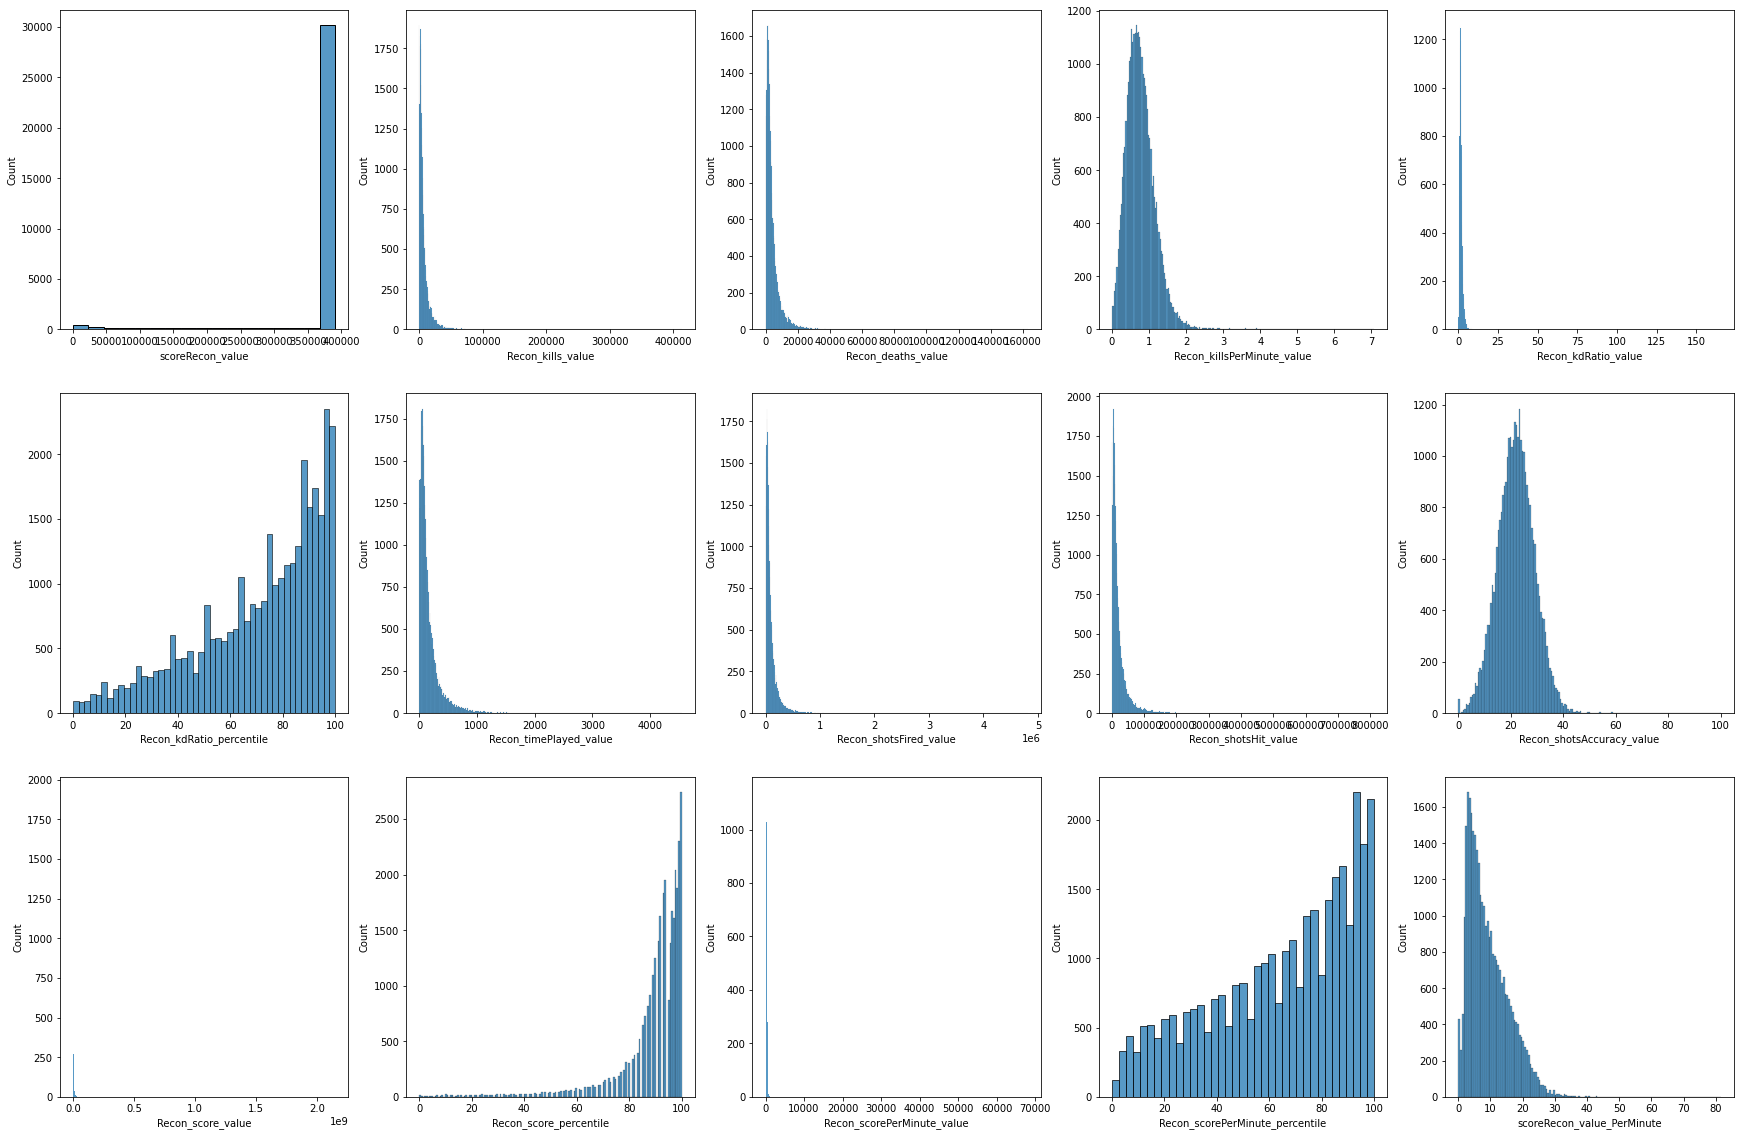

In [81]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
for ax, feat in zip(np.ravel(axes), recon_features):
    sns.histplot(data=df, x=feat, ax=ax)

## Ground Vehicle Features

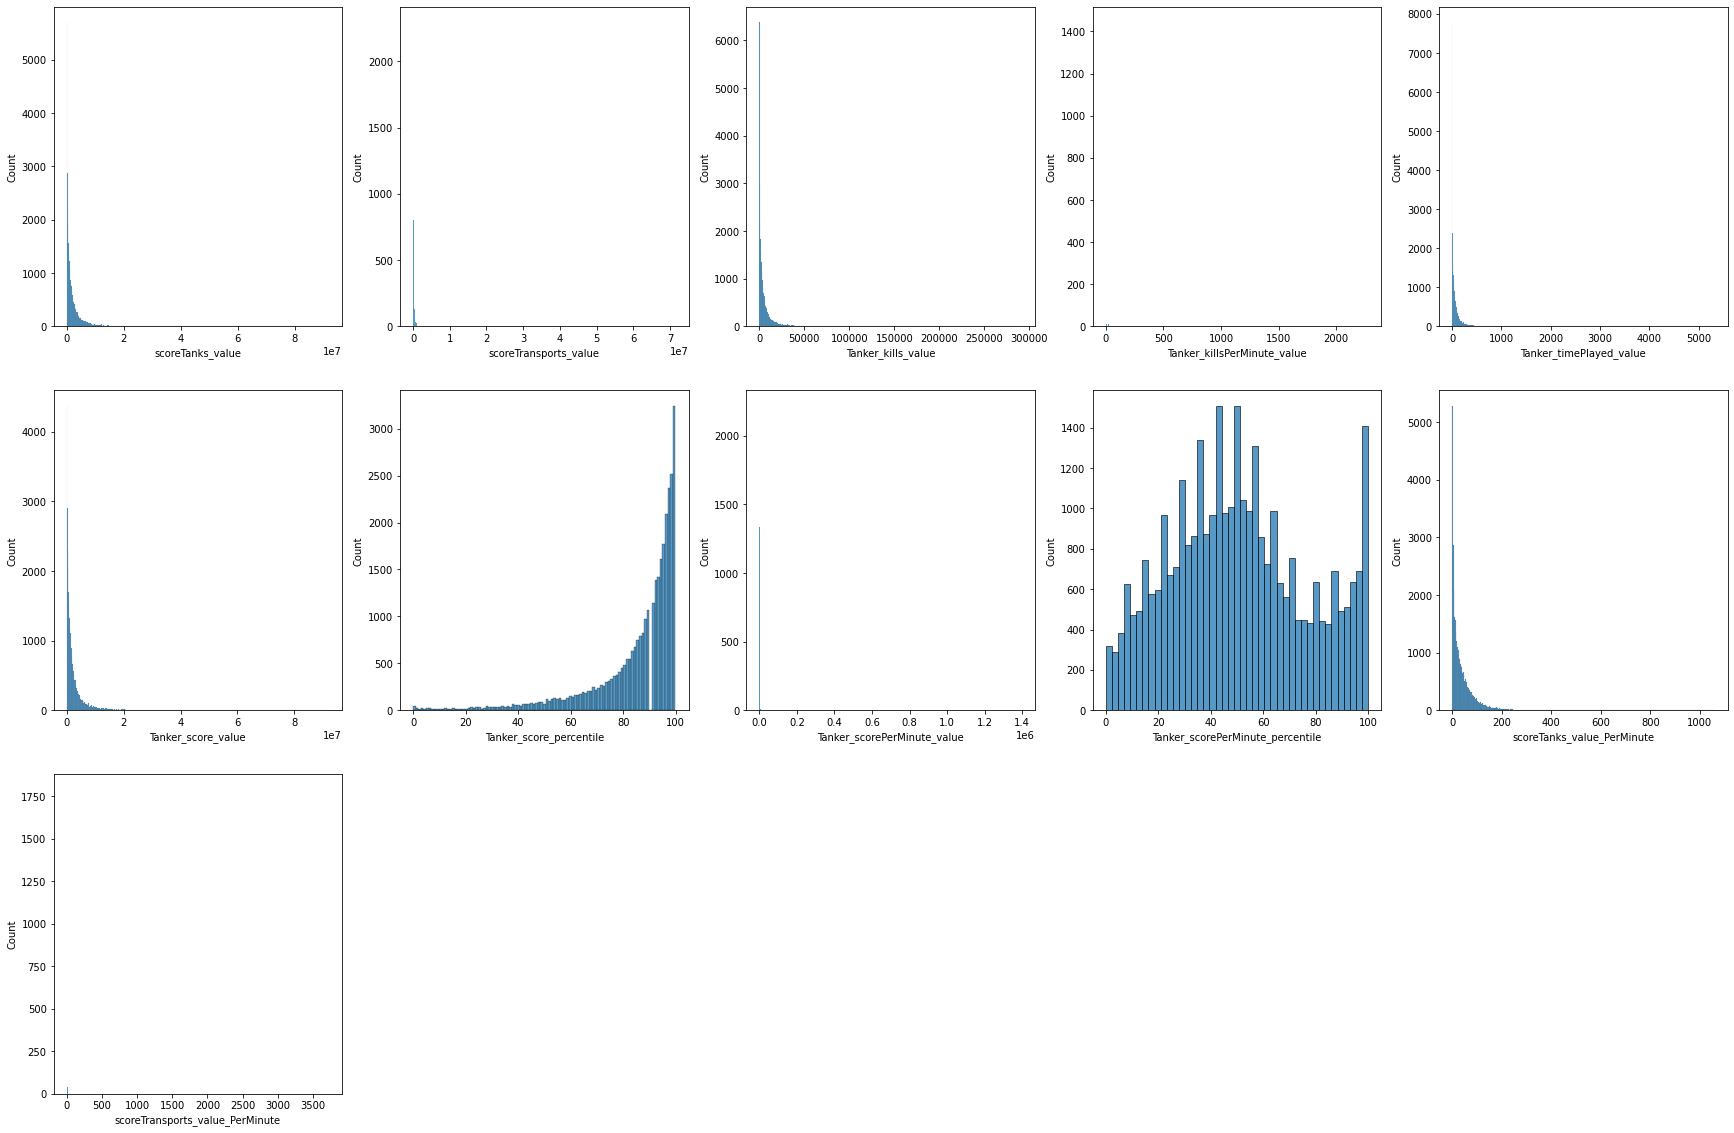

In [82]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
for ax, feat in zip(np.ravel(axes), ground_vehicle_features):
    sns.histplot(data=df, x=feat, ax=ax)

for i, ax in enumerate(np.ravel(axes)):
        if i > len(ground_vehicle_features)-1:
            ax.axis('off')

The scale of the distributions here suggest outliers in many of the ground vehicle features.

## Plane Features

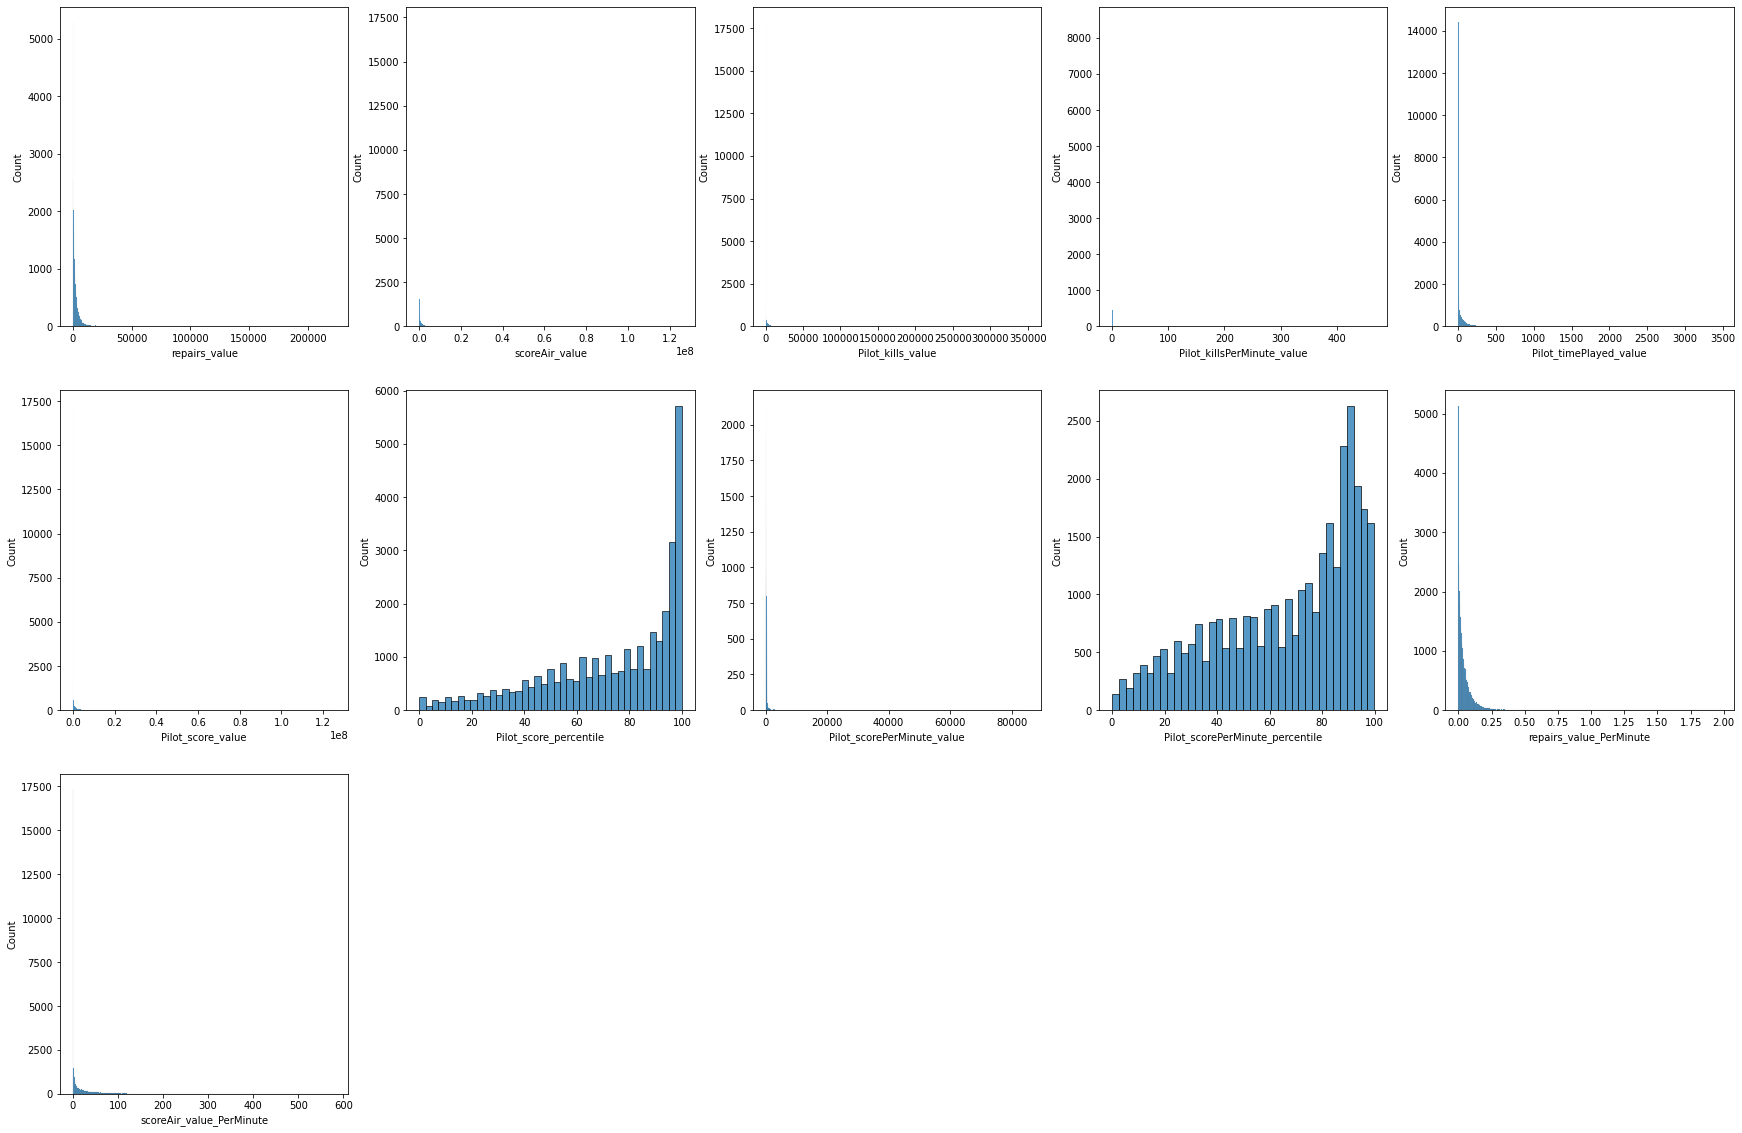

In [83]:
fig, axes = plt.subplots(3, 5, figsize=(30, 20))
for ax, feat in zip(np.ravel(axes), plane_features):
    sns.histplot(data=df, x=feat, ax=ax)

for i, ax in enumerate(np.ravel(axes)):
        if i > len(plane_features)-1:
            ax.axis('off')

## Correlations

In [140]:
high_corr = 0.5
corr_features = []
corr = df[df.columns[1:]].corr() # select only numerical features

# select only features with correlations above threshold
for feature in corr.columns: # numerical columns only
    feat_max_corr = corr[corr[feature] < 1][feature].max() # Ignore correlations of one, since all correlations on the diagonal are 1
    feat_min_corr = corr[corr[feature] < 1][feature].min()
    if np.abs(feat_min_corr) > high_corr or feat_max_corr > high_corr:
        corr_features.append(feature)

print('The following portion of features have substantial (positive or negative) correlation with other features:', len(corr_features)/len(corr.columns))
large_corr = corr[corr_features].loc[corr_features]

The following portion of features have substantial (positive or negative) correlation with other features: 0.94375


We can immediately determine from the above that almost all of the features are fairly strongly correlated with at least one other feature. This is not particularly surprising. We have, for example, certain metrics that are tracked as totals as well as per minute values, which we would expect to be correlated. We also have features that are sums of other features, for example, we track overall score but also score gained defensively. Further, given knowledge of the game, we can expect certain scores to correlate with others. We would expect, for example, score per minute to correlate with kill death ratio, as getting more kills and dying less is an effective way to score more points per minute.

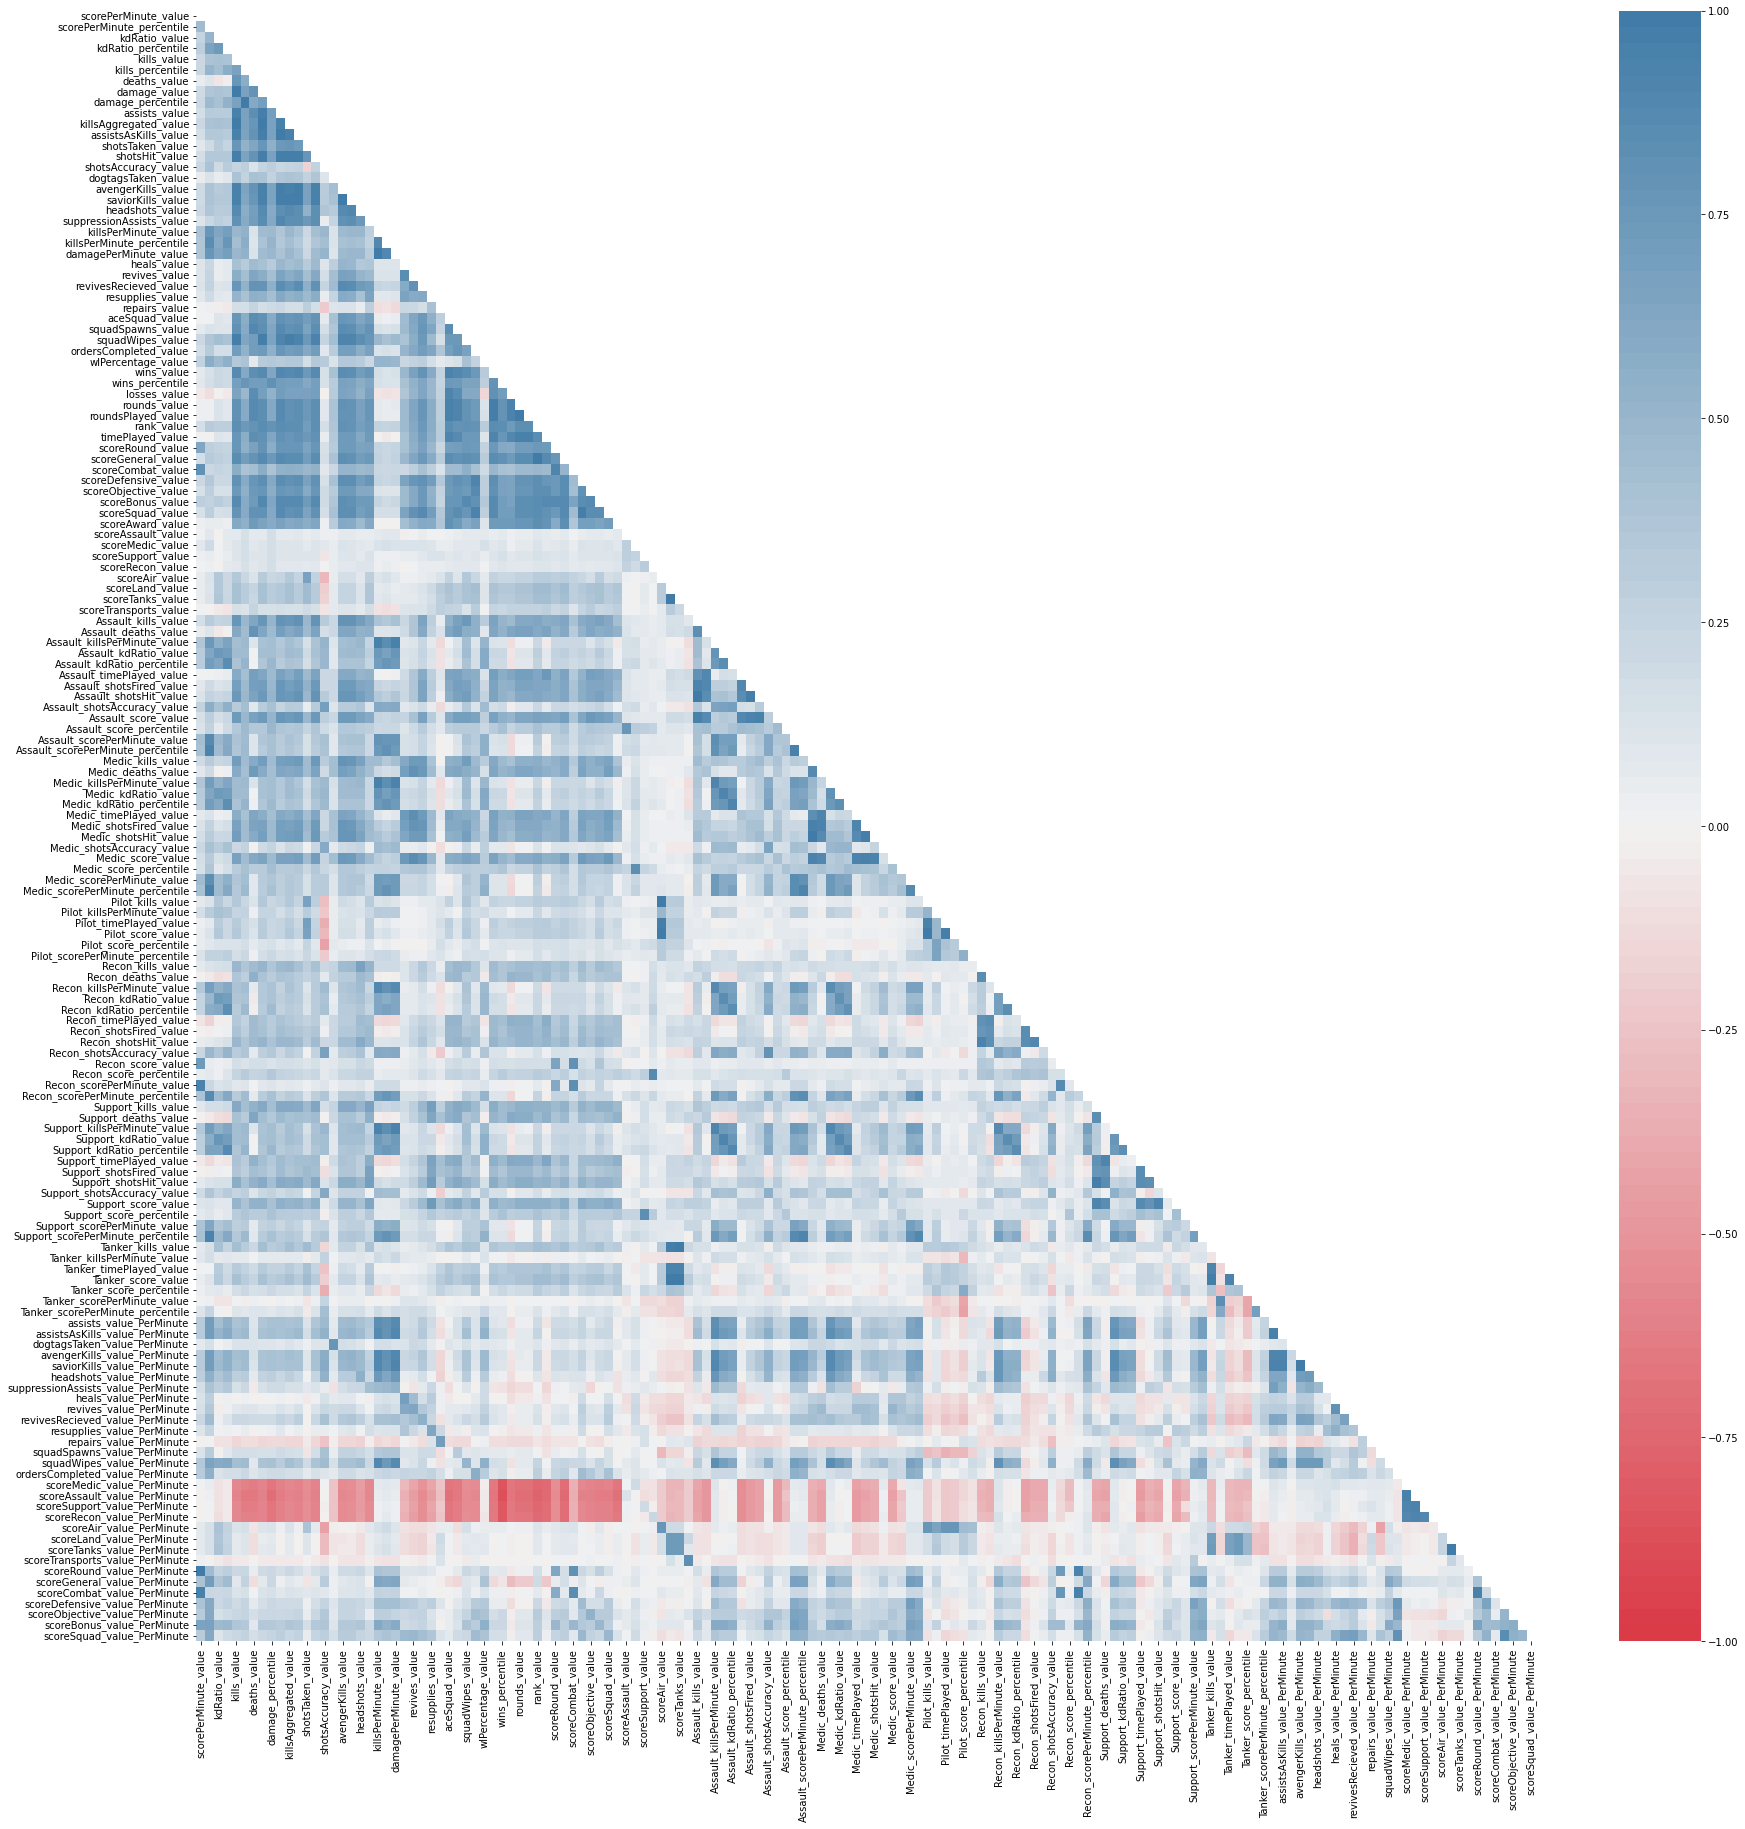

In [141]:
# Plotting correlations
mask = np.triu(large_corr)
cmap = sns.diverging_palette(10, 240, n=100)
plt.figure(figsize=(30,30))
sns.heatmap(large_corr,vmin=-1, vmax=1, cmap=cmap, mask=mask)
plt.show()

While the plot has not been marked up with values for specific correlations for the sake of readability, the phenomena discussed in the cell above the plot can be observed from looking at the plot.

It would be good to focus in on some features. To determine how to do this, I sum the absolute value of the correlation coeficients for each feature and subtract one (to account for the correlation between the feature and itself). I divide the sum by total number of features, for readability. I then sort the features by the value of that sum.

In [149]:
corr_sum = np.sum(np.abs(corr), axis=1) - 1
corr_sum = corr_sum.sort_values(ascending=False) / len(corr.columns)
print('Features with the highest total sum of absolute value of correlation coefficients')
corr_sum.head()

Features with the highest total sum of absolute value of correlation coefficients


killsAggregated_value    0.432402
kills_value              0.432190
damage_value             0.430629
saviorKills_value        0.426232
avengerKills_value       0.425525
dtype: float64

In [150]:
print('Features with the smallest total sum of absolute value of correlation coefficients')
corr_sum.tail(20)

Features with the smallest total sum of absolute value of correlation coefficients


repairs_value_PerMinute            0.100214
Tanker_killsPerMinute_value        0.094017
scoreSupport_value                 0.089910
dogtagsTaken_value_PerMinute       0.088929
scoreRecon_value                   0.083578
scoreAssault_value                 0.072293
Tanker_scorePerMinute_value        0.069478
scoreTransports_value_PerMinute    0.049967
Pilot_scorePerMinute_value         0.049637
aceSquad_value_PerMinute           0.041466
dtype: float64

We can also plot a distribution of these sums.

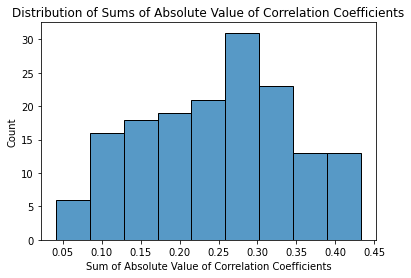

In [164]:
sns.histplot(corr_sum)
plt.xlabel('Sum of Absolute Value of Correlation Coefficients')
plt.ylabel('Count')
plt.title('Distribution of Sums of Absolute Value of Correlation Coefficients')
plt.show()

We can then plot heatmaps just looking at the ten figures with the largest and smallest average correlation respectively. First, the large average correlation features.

In [151]:
small_corr_features = corr_sum.tail(20).index
large_corr_features = corr_sum.head(20).index

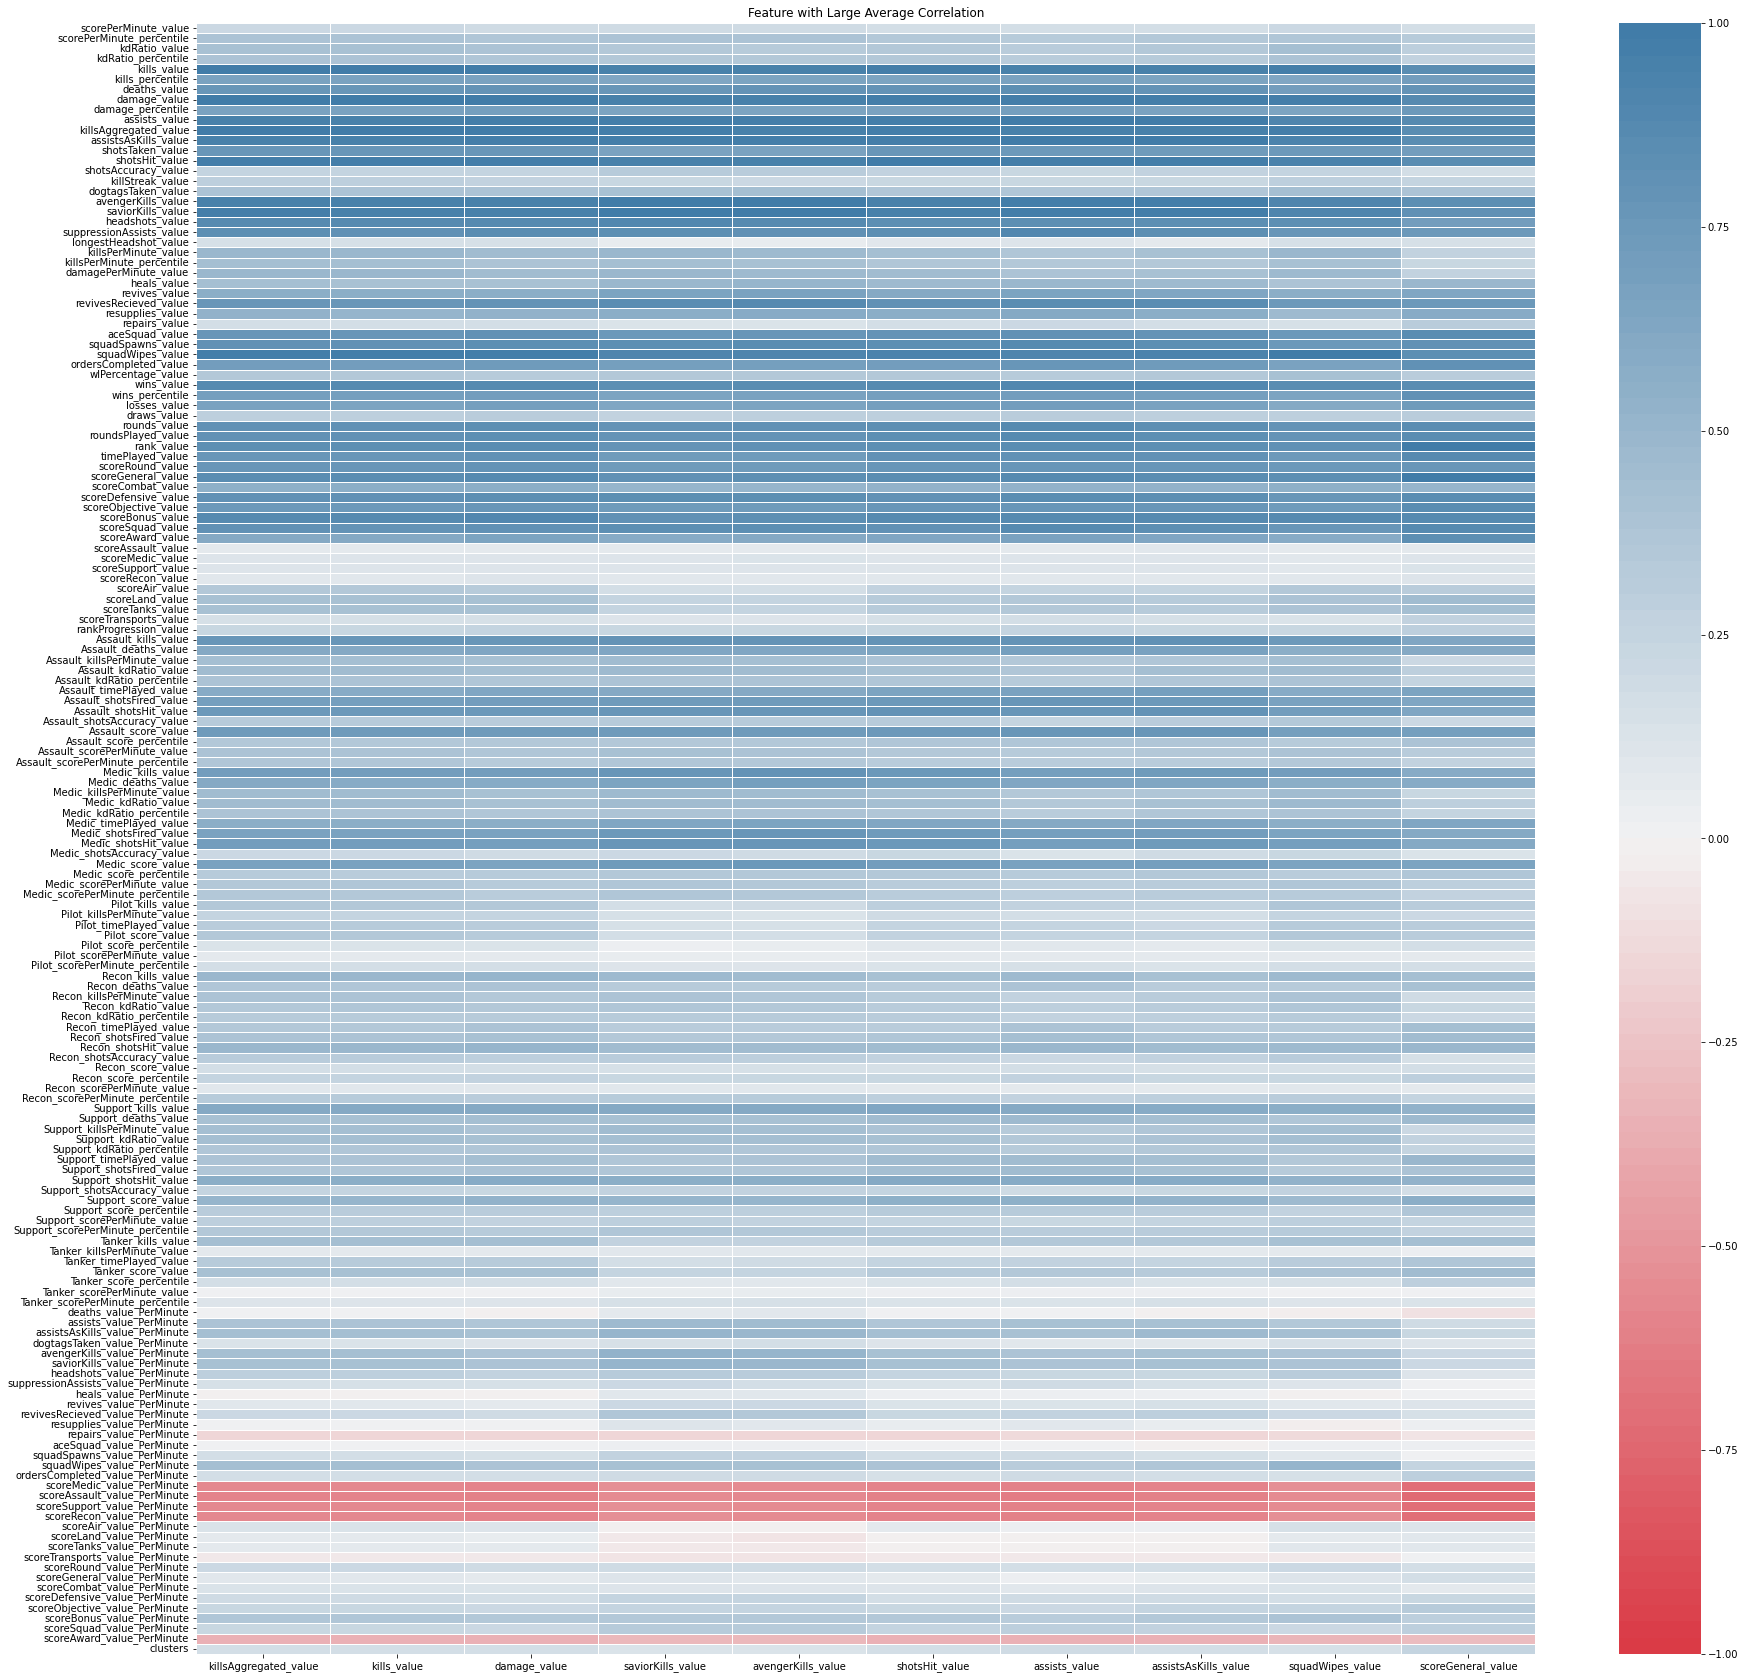

In [163]:
plt.figure(figsize=(30,30))
plt.title('Feature with Large Average Correlation')
sns.heatmap(corr[large_corr_features], vmin=-1, vmax=1, cmap=cmap, linewidths=0.5)
plt.show()

Next the features with small correlations.

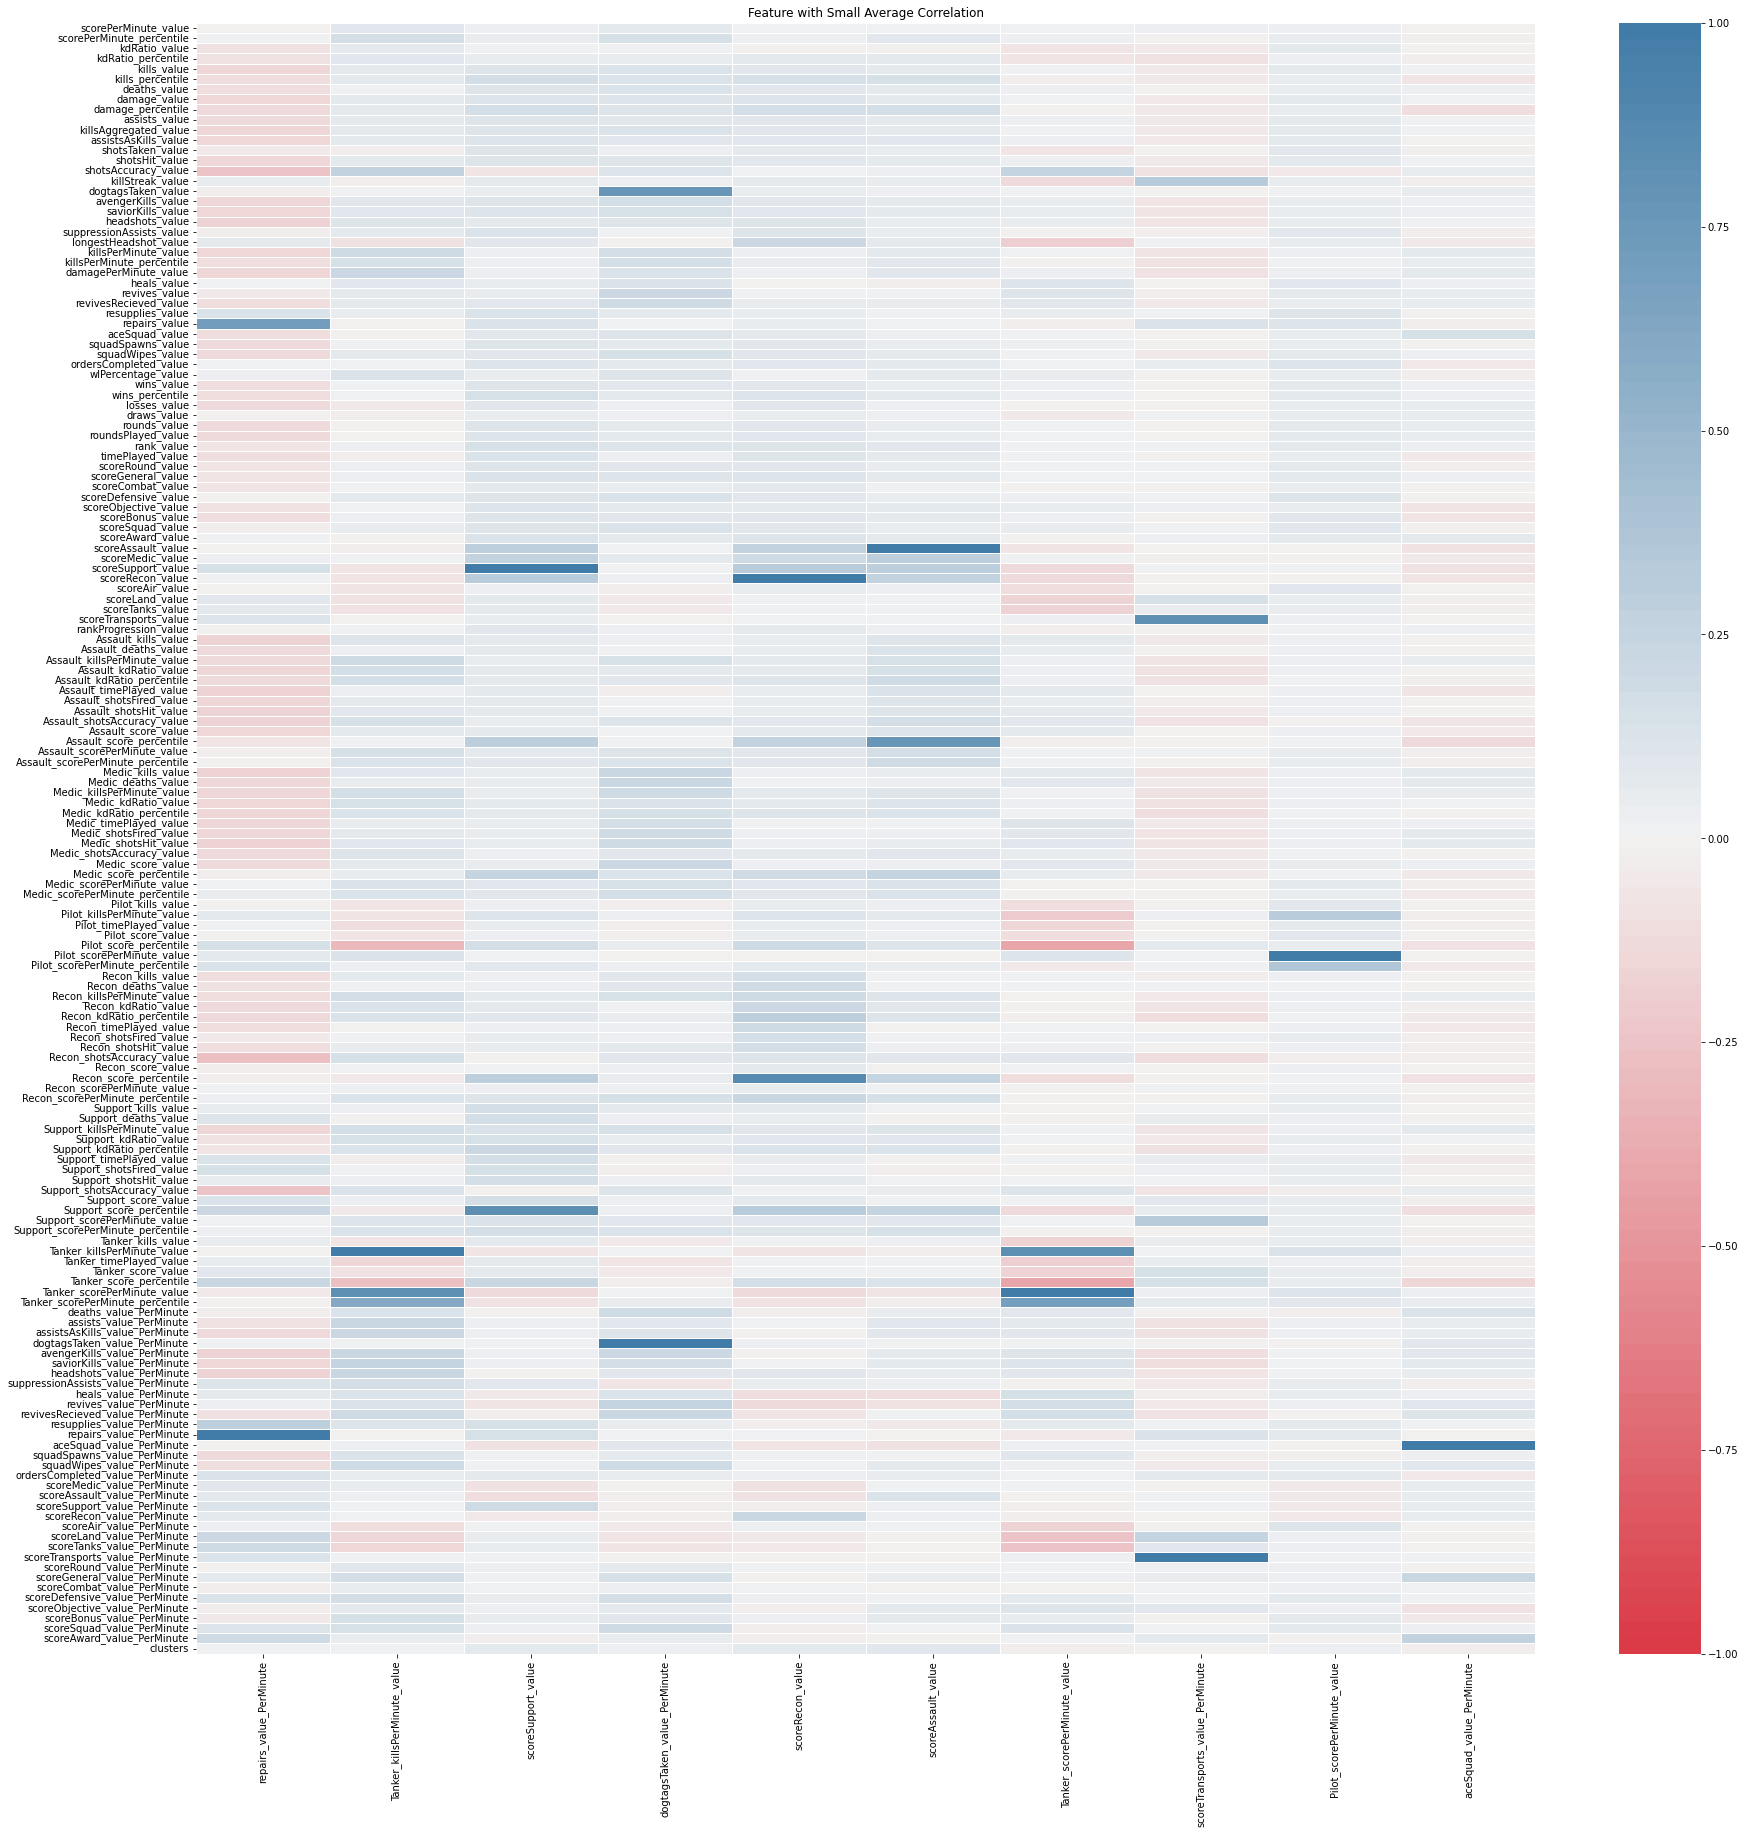

In [165]:
plt.figure(figsize=(30,30))
plt.title('Feature with Small Average Correlation')
sns.heatmap(corr[small_corr_features], vmin=-1, vmax=1, cmap=cmap, linewidths=0.5)
plt.show()

## Outliers
The game has a known problem with cheaters, for example, people who use aimbots. I would prefer to remove these players from the dataset, as they are not representative of average players skills. I examine whether such players are in the dataset using basic statistical methods and domain knowledge. Given the fairly significant cheater problem in the game, I am fairly conservative at times.

One thing to note here is that raw values are going to be poor for detecting outliers by themselves. If I am terrible at the game but play 6 hours a day for years, I will likely have more kills than an excellent player who only plays 2 hours per week. However, they will likely have more kills per minute or kill death ratios. So when looking for outliers, I use features adjusted for time when possible.

Outlier detection will also be important for clustering. To cluster, I will be using KMeans. This algorithm computes cluster centers as the mean value of points in a cluster. The mean is sensetive to outliers (ex. consider the means of [1,2,3,4,5] and [1,2,3,1000,5]), thus KMeans will be sensitive to outliers. This of course does not mean that we can remove samples with a large value in a feature simply because the value is large.

### Medic and Assault Score per Minute
Note here the features are features for the score of the class averaged over total playtime, not score for the class averaged over playtime for the class.

In [89]:
high_medic_support_score = df[(df['scoreAssault_value_PerMinute'] > 50) | (df['scoreMedic_value_PerMinute'] > 50)]
high_medic_support_score[['Medic_timePlayed_value', 'Assault_timePlayed_value', 'scoreAssault_value_PerMinute', 'scoreMedic_value_PerMinute']]

,Medic_timePlayed_value,Assault_timePlayed_value,scoreAssault_value_PerMinute,scoreMedic_value_PerMinute
5444,0.327778,3.937500,171.648000,15.586909
5945,23.408333,4.279167,154.699388,231.088288
25527,4.393056,3.473611,40.549051,96.604881
27047,7.736111,46.054167,70.749369,31.084914


That value of score per minute is implausible and made even more so by the fact that it has only been achieved by 2 players with low playtimes in the classes for which their score per minute is high. Those samples are removed.

In [90]:
df = df[(df['scoreAssault_value_PerMinute'] < 50) & (df['scoreMedic_value_PerMinute'] < 50)]

### Medic and Support Accuracy
Some players have accuracy values with the medic and support class greater than or equal to 100, which should be impossible. These players are examined then removed.

In [91]:
df[(df['Support_shotsAccuracy_value'] >= 100)  | (df['Medic_shotsAccuracy_value'] >= 100)]

,platform,scorePerMinute_value,scorePerMinute_percentile,kdRatio_value,kdRatio_percentile,kills_value,kills_percentile,deaths_value,damage_value,damage_percentile,...,scoreTanks_value_PerMinute,scoreTransports_value_PerMinute,scoreRound_value_PerMinute,scoreGeneral_value_PerMinute,scoreCombat_value_PerMinute,scoreDefensive_value_PerMinute,scoreObjective_value_PerMinute,scoreBonus_value_PerMinute,scoreSquad_value_PerMinute,scoreAward_value_PerMinute
2737,psn,556.713934,96.9,3.875630,97.8,262198,99.9,67653,28235365,99.8,...,179.756219,0.659133,556.711282,533.288027,282.067442,84.783646,192.920674,81.437880,55.998775,44.349094
6208,origin,448.875556,87.0,2.041905,86.0,95359,98.7,46701,11835206,98.8,...,6.247949,1.384529,448.872219,514.194524,181.453592,103.375217,165.102307,77.627697,70.053287,71.565526
8699,psn,313.614959,49.0,2.428641,91.0,74382,98.0,30627,9282287,98.1,...,82.181553,1.790425,313.614404,404.845862,168.105976,64.121979,81.894537,45.271479,31.822285,46.268575
8852,psn,199.577917,14.0,3.217197,96.5,74980,98.0,23306,9281655,98.1,...,0.013504,0.002446,199.577917,263.317609,173.259168,25.411370,0.902128,28.062447,21.233931,50.825231
12726,psn,215.988639,17.0,1.605479,74.0,48463,96.3,30186,5872058,96.3,...,0.007541,0.000979,215.985995,333.803803,187.147999,28.388698,0.449298,29.069843,27.635763,88.747965
12746,xbl,421.173237,81.0,2.120341,87.0,58250,97.1,27472,7191342,97.2,...,72.875869,1.315082,421.168420,517.000366,228.047795,116.557802,76.799259,67.329938,54.879540,55.346768
13398,origin,402.768151,77.0,1.989561,85.0,59273,97.2,29792,6671597,96.8,...,0.776368,0.361034,402.763249,342.922616,217.705799,86.274220,98.721168,60.033952,43.082884,73.092790
19607,origin,565.794065,97.3,1.740373,78.0,44517,95.9,25579,4791111,95.2,...,2.770939,1.641597,565.781068,400.775946,195.840835,156.935907,213.070509,108.001929,108.279464,26.987834
19702,origin,504.310622,93.0,1.811954,80.0,43563,95.8,24042,5552065,96.0,...,4.254617,4.538232,504.305156,597.512293,189.754336,90.780670,223.862294,66.537222,63.013938,82.607913
20034,origin,567.473288,97.3,2.163468,88.0,44522,95.9,20579,4930928,95.4,...,1.984907,0.971002,567.459722,676.491541,241.777625,171.686958,154.013053,83.202843,87.250560,64.540087


They are all dropped from the dataset.

In [92]:
df = df[(df['Support_shotsAccuracy_value'] < 100)  & (df['Medic_shotsAccuracy_value'] < 100)]

### Class Kill Death Ratio
If asked, I would say that the player I know of with the best kill/death ratio has a kill/death ratio of about 5. This is an [outstanding player](https://battlefieldtracker.com/bfv/profile/psn/MaxiqYT/overview) with nearly 5000 hours played. They are essentially a minor celebrity for their kill/death ratio. So considering this as background, as well as general knowledge about Battlefield 5 specifically and FPS games in general, kill/death ratios of 6 or especially 7 and above strike me as essentially impossible to achieve with the so-called "infantry" classes in the game. One way this may be possible is if a player has a high k/d ratio for a class but low time playing the class. To examine the suspected outliers, I plot the kill/death ratio for each feature above a threshold of 6 against time played for the respective class.

In [93]:
[feat for feat in df.columns if 'time' in feat.lower()]

['timePlayed_value',
 'Assault_timePlayed_value',
 'Medic_timePlayed_value',
 'Pilot_timePlayed_value',
 'Recon_timePlayed_value',
 'Support_timePlayed_value',
 'Tanker_timePlayed_value']

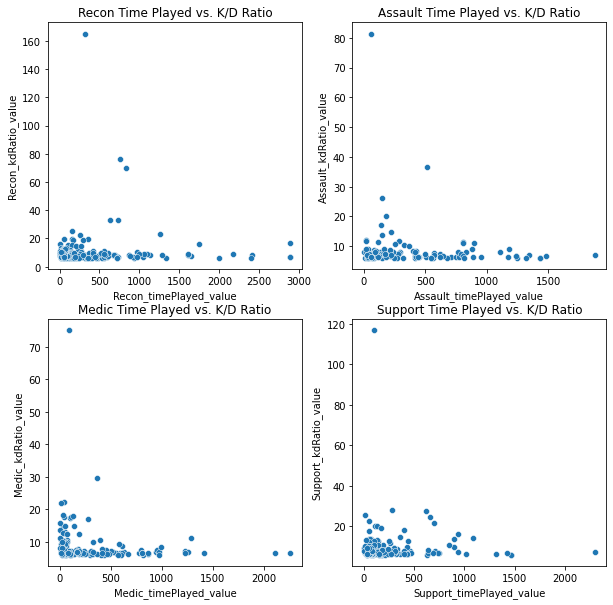

In [94]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))
classes = ['Recon', 'Assault', 'Medic', 'Support']
for ax, infantry_class in zip(np.ravel(axes), classes):
    df_subset = df[df[f'{infantry_class}_kdRatio_value'] > 7][[f'{infantry_class}_timePlayed_value', f'{infantry_class}_kdRatio_value']]
    sns.scatterplot(data=df[df[f'{infantry_class}_kdRatio_value'] > 6], x=f'{infantry_class}_timePlayed_value', y=f'{infantry_class}_kdRatio_value', ax=ax)
    ax.set_title(f'{infantry_class} Time Played vs. K/D Ratio')

We see no strong relationship between time played for a various class and the kill/death ratio for the class. Further, noting that time played is given in hours, we also do not see the phenomena of a player having a very good kill/death ratio for a class but a very short time played for the class. As such, all of these outliers are removed.

In [95]:
for infantry_class in classes:
    df = df[df[f'{infantry_class}_kdRatio_value'] < 7]

### Tank Score per Minute
The distribution of score per minute for tanks immediately stands out. I do not know much about vehicles in the game, but I know that 1M score per minute is essentially impossible, especially sustained over a long period of time. Additionally, it is easier to get kills with planes, but the score per minute distribution in planes is much more reasonable.

In [96]:
tank_spm = df['Tanker_scorePerMinute_value']
tank_spm.describe()

count    3.273700e+04
mean     3.290598e+03
std      2.400977e+04
min      0.000000e+00
25%      4.621437e+02
50%      5.886874e+02
75%      9.498194e+02
max      1.398175e+06
Name: Tanker_scorePerMinute_value, dtype: float64

We can see here that most of the values are in the hundreds or low thousands, making the 1M score range value(s) look even more suspicious. To further examine them, I look only at values above the 3rd quartile.

In [97]:
num_best_tankers = len(df[tank_spm > 10_000])
print(f'Only {num_best_tankers} have a score per minute in tanks over 10,000.')
tank_spm[tank_spm > np.quantile(tank_spm, q=0.75)].describe()

Only 1492 have a score per minute in tanks over 10,000.


count    8.184000e+03
mean     1.154694e+04
std      4.706579e+04
min      9.498571e+02
25%      1.365073e+03
50%      2.529045e+03
75%      6.579429e+03
max      1.398175e+06
Name: Tanker_scorePerMinute_value, dtype: float64

We can see here that the top 25% of the top 25% players with the highest score per minute in tanks would be outstanding to maintain a score perminute of 10,000. I feel confident in treating the players above that threshold as outliers.

In [98]:
df = df[df['Tanker_scorePerMinute_value'] <= 10_000]

We can then revisualize the distribution of score per minute in tanks.

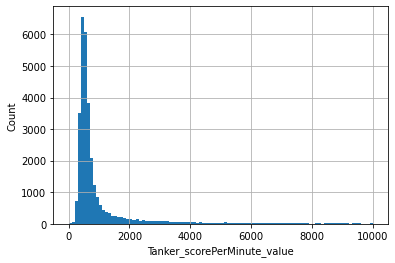

In [99]:
df['Tanker_scorePerMinute_value'].hist(bins=100)
plt.ylabel('Count')
plt.xlabel('Tanker_scorePerMinute_value')
plt.show()

This looks like what we expect based on the other plots.

#### Tank Kills per Minute
The tank kills per minute distribution also looks unusual. You can think of pilot kills per minute as a rough proxy for what the distribution for tanks should look like, except tank kills per minute should probably be lower. Getting hundreds of kills per minute is impossible for human players. Removing the score per minute outliers may have removed outliers in this feature, but it is best to check.

In [100]:
df['Tanker_killsPerMinute_value'].describe()

count    31245.000000
mean         1.846533
std          2.758590
min          0.000000
25%          1.052406
50%          1.371372
75%          1.857143
max        350.875000
Name: Tanker_killsPerMinute_value, dtype: float64

We see above that there is still at least one implausible value, 119. A sustained value of 119 kills per minute with tanks is impossible. I check values over 20 to get a general idea of how much of an outlier the maximum value is.

In [101]:
df[df['Tanker_killsPerMinute_value'] > 20]['Tanker_killsPerMinute_value']

1062     350.875000
3295      22.219512
3732      23.000000
6264      23.326733
8748      21.757576
8971     119.400000
20368     21.701299
21659     27.840000
22105     24.750000
22550     21.000000
23688     60.000000
24287     23.944767
26032     22.777778
26538     26.000000
27450     33.250000
29255     23.393939
32596     28.500000
Name: Tanker_killsPerMinute_value, dtype: float64

I remove the highest values manually. It is worth noting that other values here may be outliers worthy of removal, but I would have to ask someone more familiar with tank gameplay.

In [102]:
df = df[df['Tanker_killsPerMinute_value'] < 100]

### Tank Plots
Removing the outliers from the tank score per minute plots should have made them more readable, so I plot them again below.

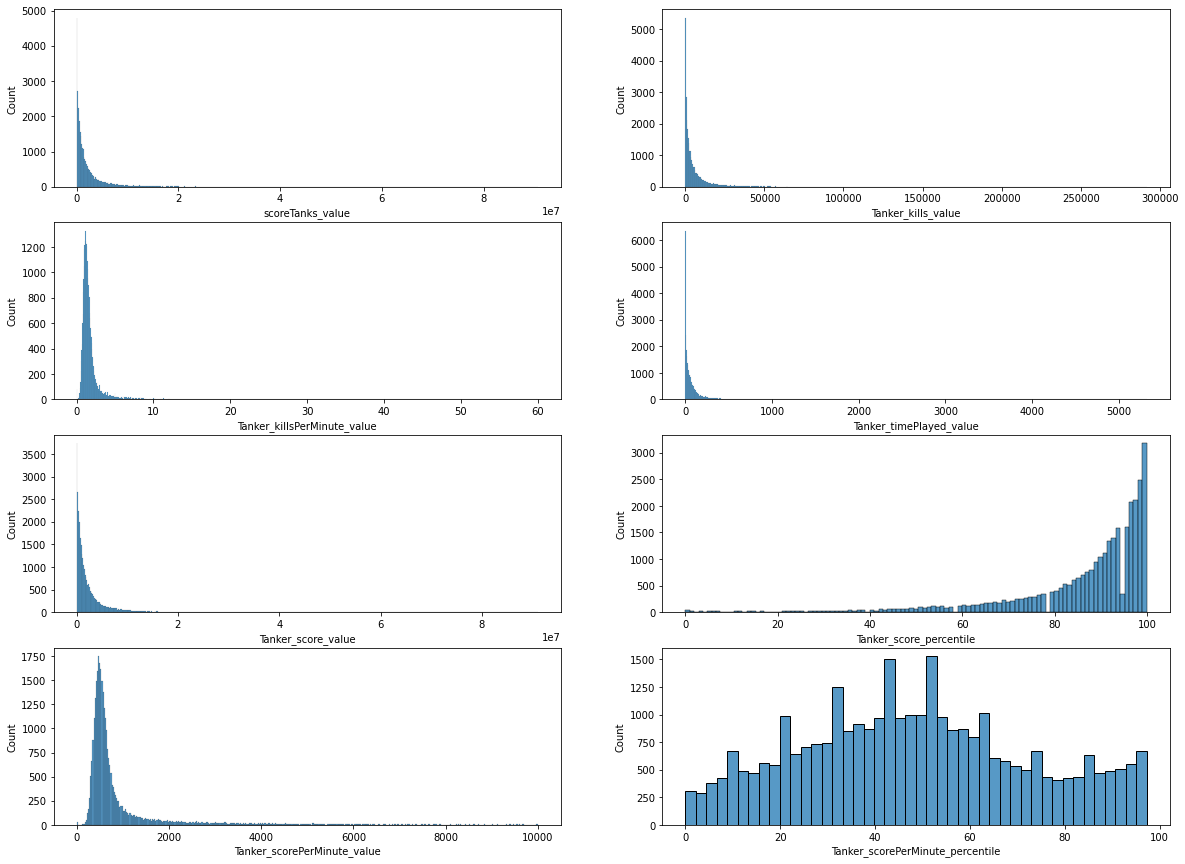

In [103]:
tank_features = [feature for feature in df.columns if 'tank' in feature.lower()]
fig, axes = plt.subplots(4,2, figsize=(20,15))

for ax, feature in zip(np.ravel(axes), tank_features):
    sns.histplot(data=df, x=feature, ax=ax)

### Plane Kills Per Minute
The Pilot_killsPerMinute_value feature has at least one value of around 250 kills per minute. This value is impossible to achieve. It and any other outliers will be removed.

In [104]:
df['Pilot_killsPerMinute_value'].describe()

count    31243.000000
mean         0.454010
std          3.154826
min          0.000000
25%          0.050000
50%          0.239583
75%          0.691212
max        467.000000
Name: Pilot_killsPerMinute_value, dtype: float64

We can see here that the maximum value really stands out, but I also check for other large values below.

In [105]:
df[df['Pilot_killsPerMinute_value'] <= 5]['Pilot_killsPerMinute_value'].describe()

count    31219.000000
mean         0.415402
std          0.462221
min          0.000000
25%          0.050000
50%          0.238806
75%          0.690353
max          5.000000
Name: Pilot_killsPerMinute_value, dtype: float64

In [106]:
df = df[df['Pilot_killsPerMinute_value'] < 5]

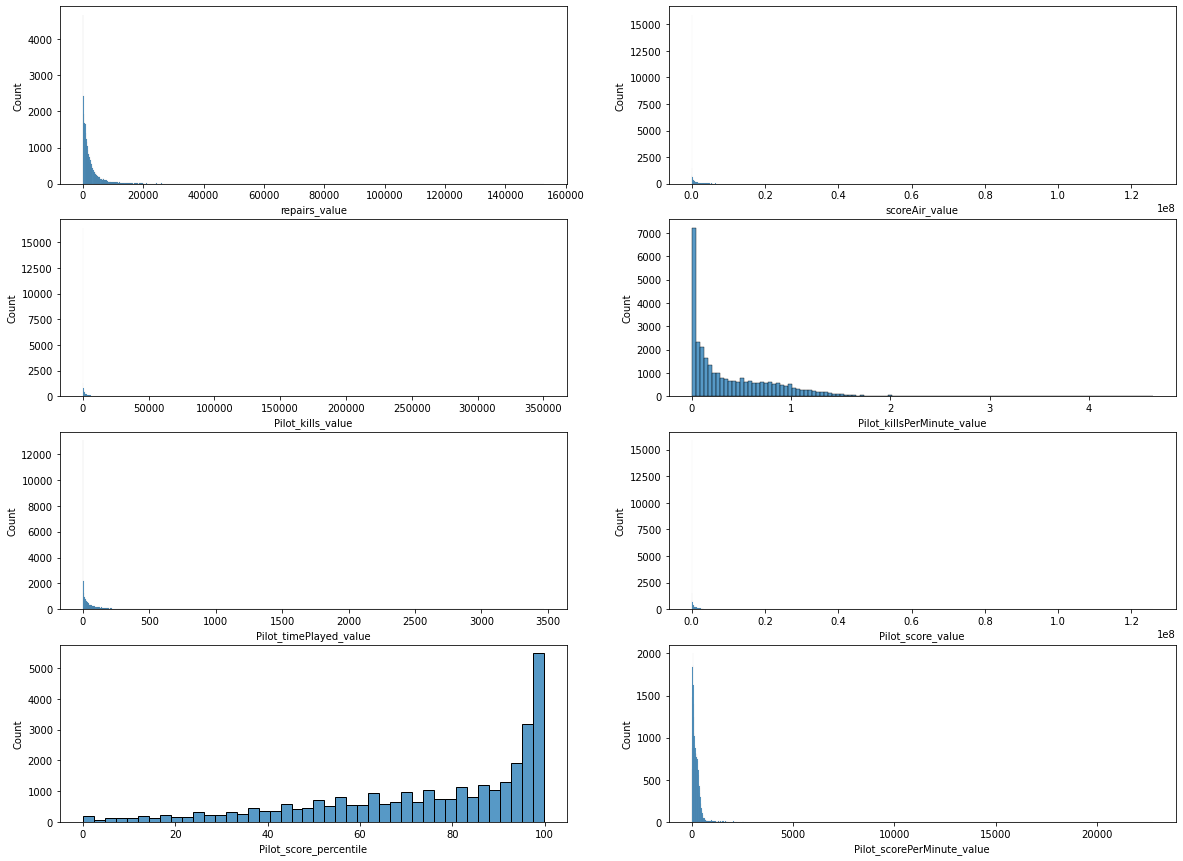

In [107]:
fig, axes = plt.subplots(4,2, figsize=(20,15))

for ax, feature in zip(np.ravel(axes), plane_features):
    sns.histplot(data=df, x=feature, ax=ax)

# Missing Values

<AxesSubplot:>

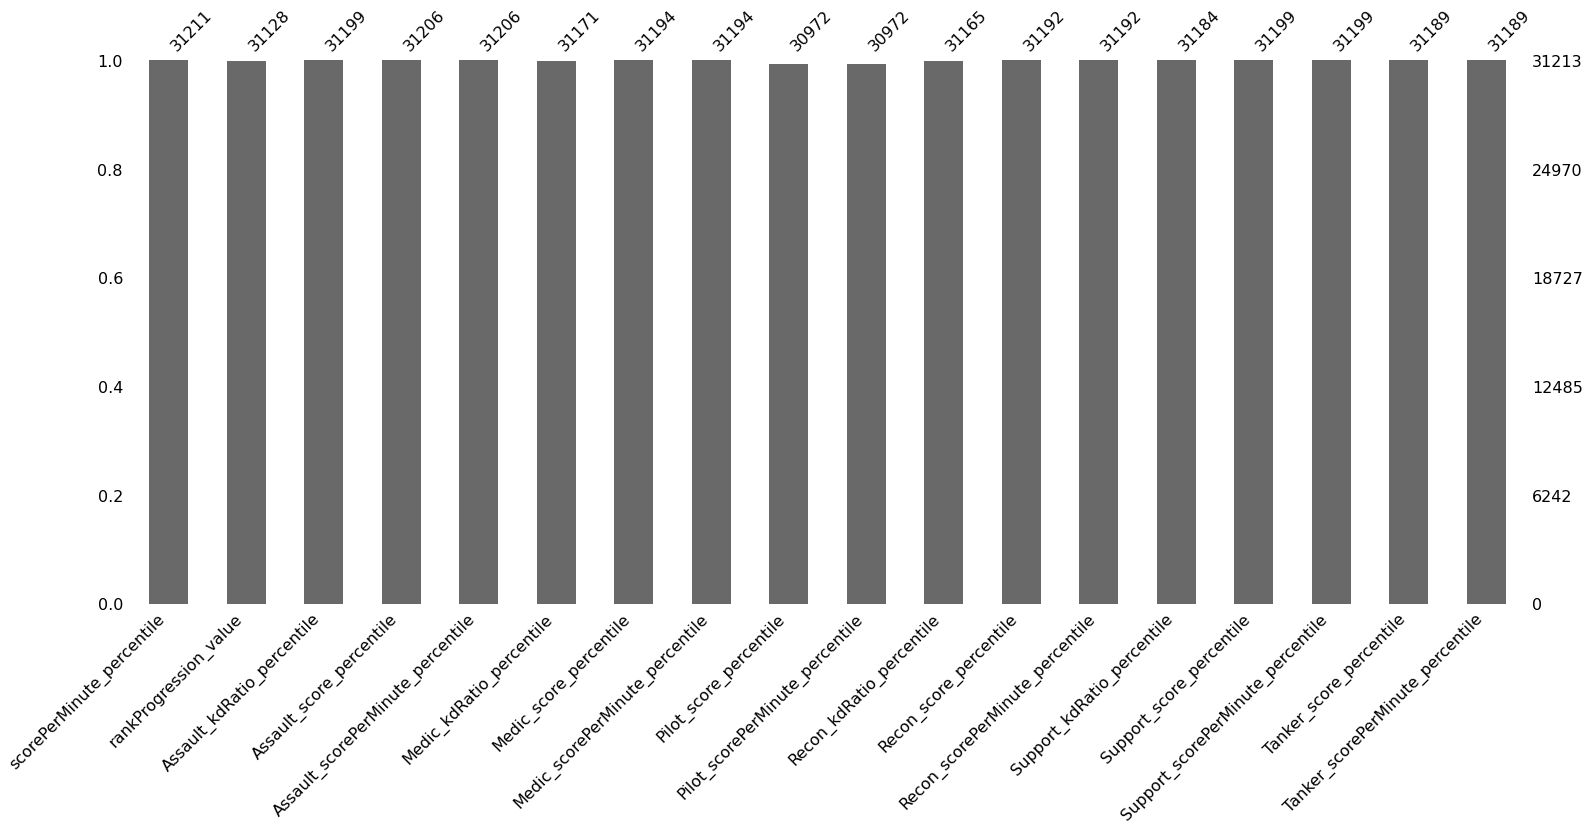

In [108]:
features_with_nan = [feature for feature in df.columns if df[feature].isnull().sum() > 0]
missingno.bar(df[features_with_nan])

There are few enough features that I simply replace missing values with the mean value of the feature.

In [109]:
df_imputed = df
for feature in features_with_nan:
    df_imputed[feature] = df[feature].fillna(df[feature].mean())

In [110]:
ss = StandardScaler()
df_scaled = ss.fit_transform(df_imputed[df.columns[2:]])

pca = PCA()
pca_features = pca.fit_transform(df_scaled)

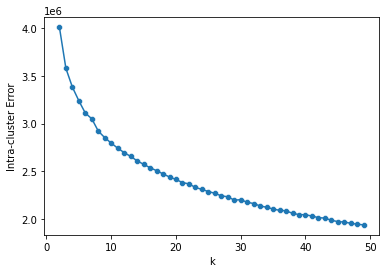

In [111]:
k_range = range(2, 50)
sse = []

for k in k_range:
    kmeans = KMeans(random_state=123, n_clusters=k)
    kmeans.fit(pca_features)
    sse.append(kmeans.inertia_)

sns.lineplot(x=k_range, y=sse)
sns.scatterplot(x=k_range, y=sse)
plt.xlabel('k')
plt.ylabel('Intra-cluster Error')
plt.show()

<AxesSubplot:>

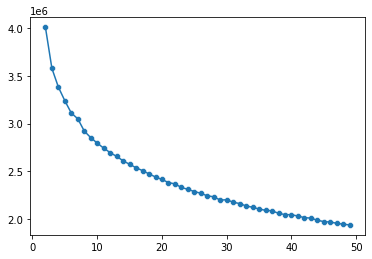

In [112]:
sns.lineplot(x=k_range, y=sse)
sns.scatterplot(x=k_range, y=sse)

In [113]:
k=5
kmeans = KMeans(random_state=123, n_clusters=k)
kmeans.fit(df_scaled)
clusters = kmeans.labels_

In [114]:
pcs = [f'pc_{i+1}' for i in range(pca_features.shape[1])]
df_pca = pd.DataFrame(pca_features, columns=pcs)

Text(0.5, 1.0, '5 Clusters Projected onto First Two Principal Coordinates')

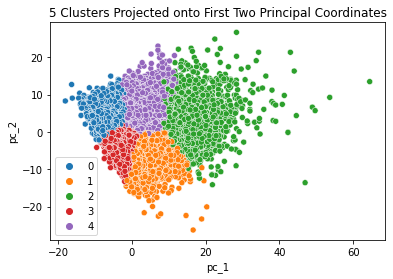

In [115]:

sns.scatterplot(data=df_pca, x='pc_1', y='pc_2', hue=clusters, palette='tab10')
plt.title(f'{k} Clusters Projected onto First Two Principal Coordinates')

## Analyzing Features by Cluster

In [116]:
def plot_cluster_stats(features, num_x_plots, num_y_plots, height=25, width=25):
    df_subset = df[features+['clusters']].groupby('clusters').agg(['mean', 'std'])
    fig, axes = plt.subplots(num_y_plots, num_x_plots, figsize=(width, height))
    clusters = np.array(range(1, k+1))
    for feature, ax in zip(features, np.ravel(axes)):
        # Plot means
        ax.bar(x=clusters - 0.2, height=df_subset[feature]['mean'], width=0.4)

        # Plot standard deviations
        ax.bar(x=clusters + 0.2, height=df_subset[feature]['std'], width=0.4)

        ax.set_title(feature)
        ax.set_xlabel('Cluster')

    for i, ax in enumerate(np.ravel(axes)):
        if i > len(features)-1:
            ax.axis('off')
    plt.show()

df['clusters'] = kmeans.labels_

### General Features

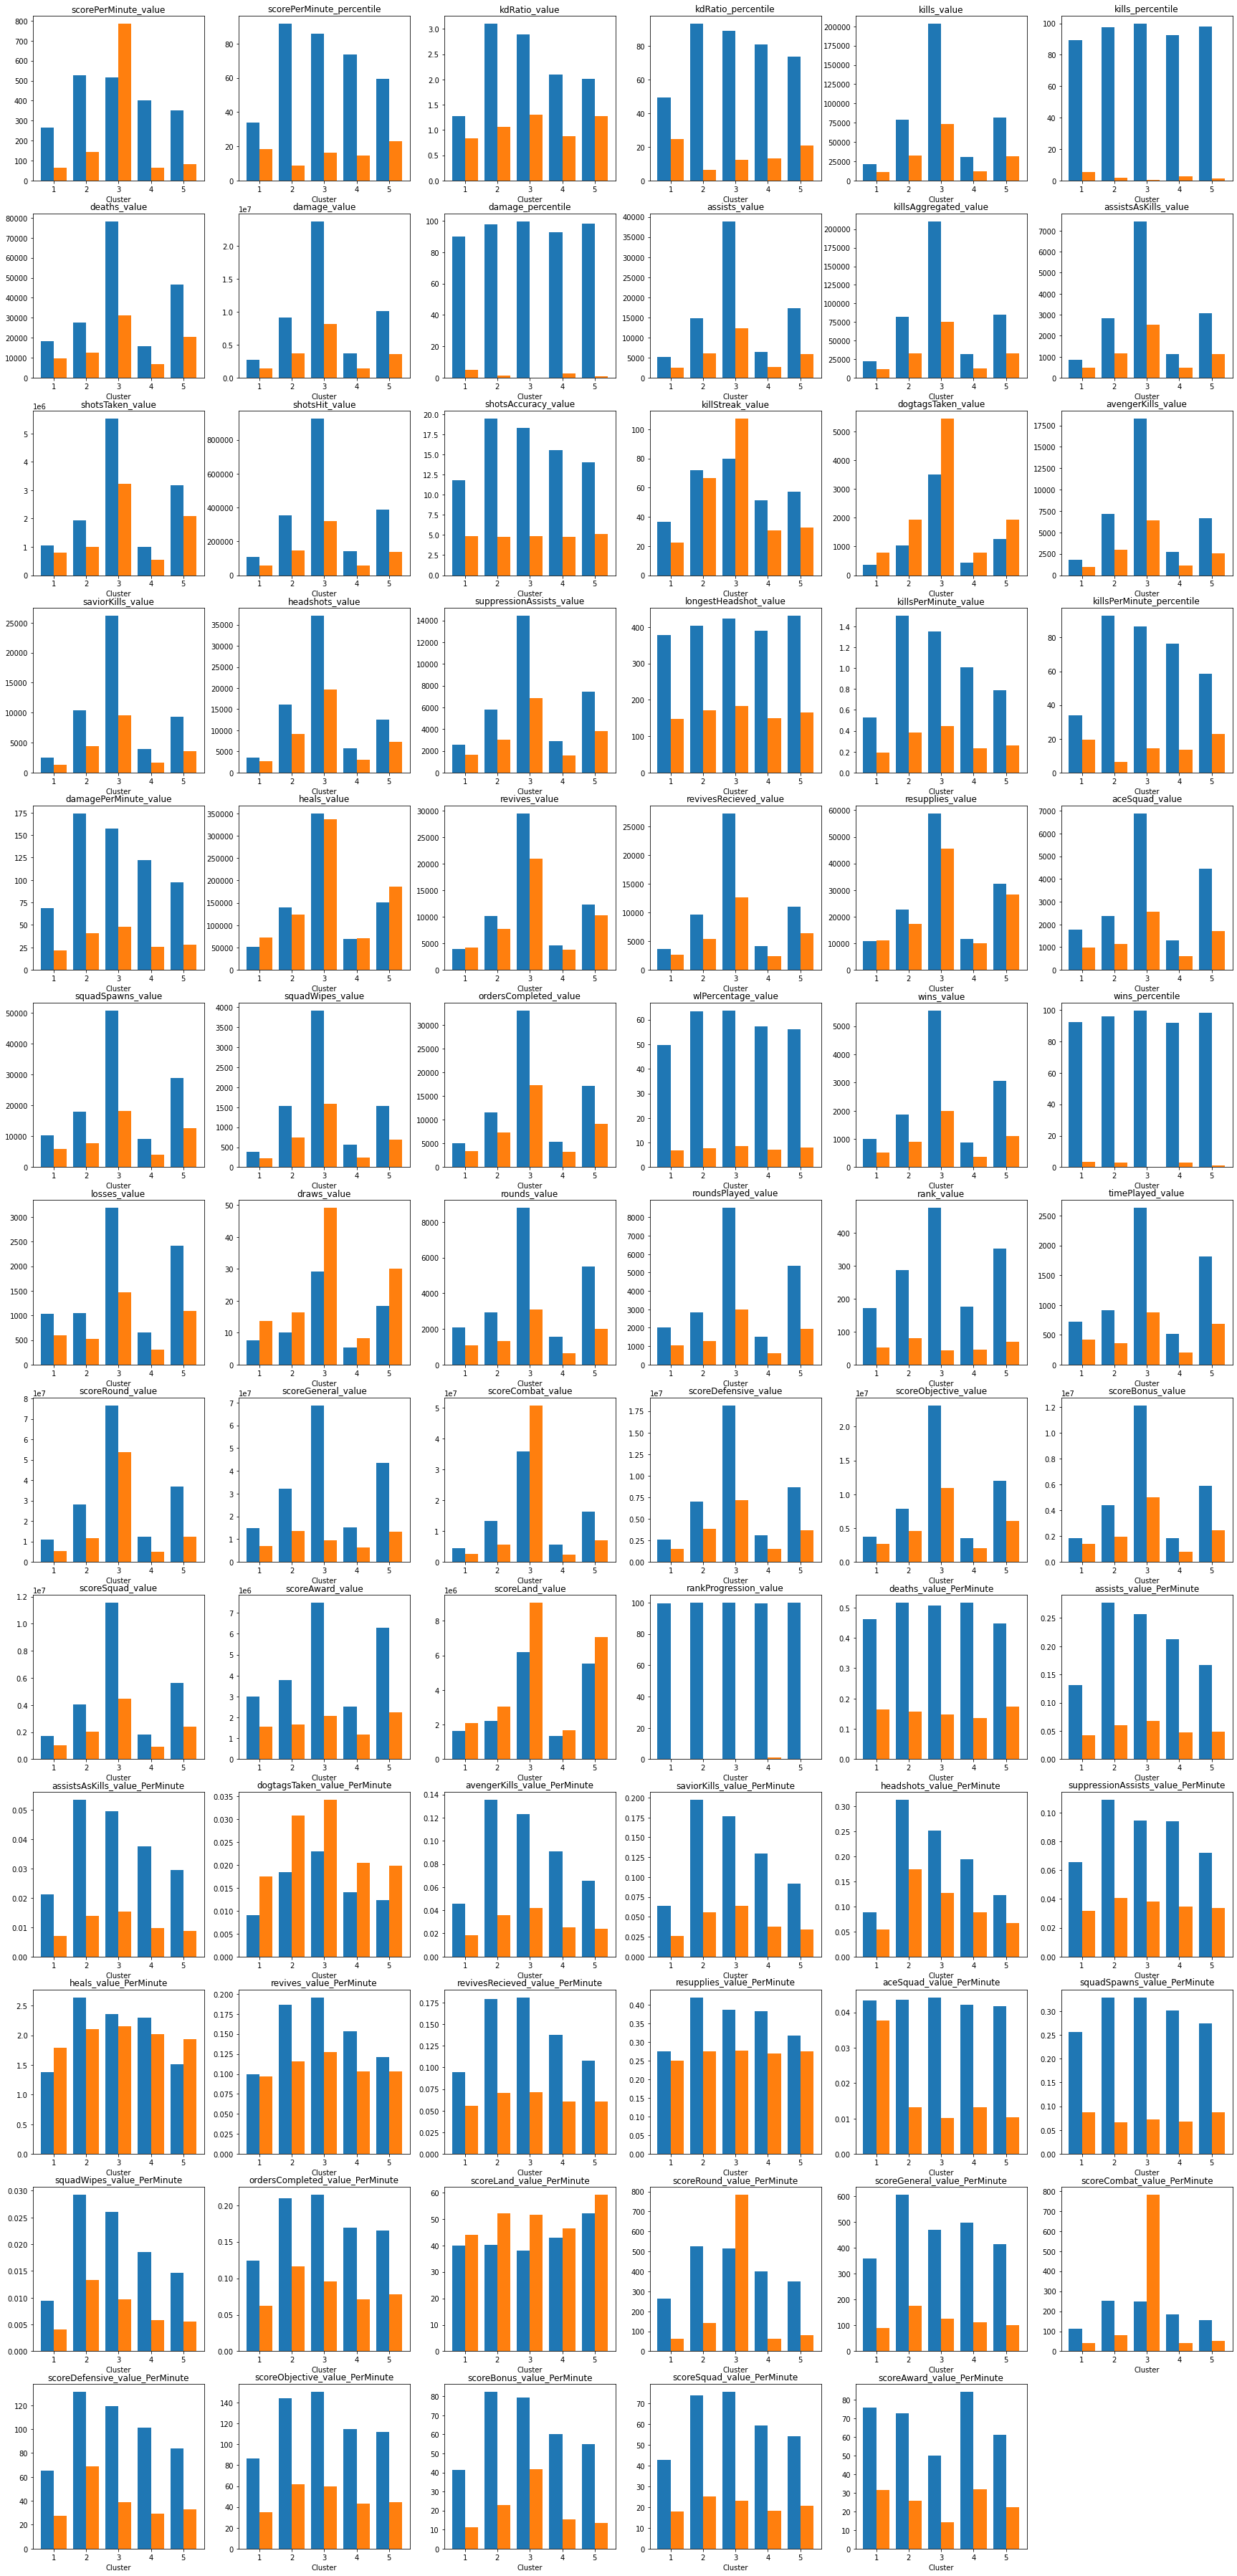

In [117]:
plot_cluster_stats(general_features[1:], 6, 13, height=65, width=30)

### Medic Features

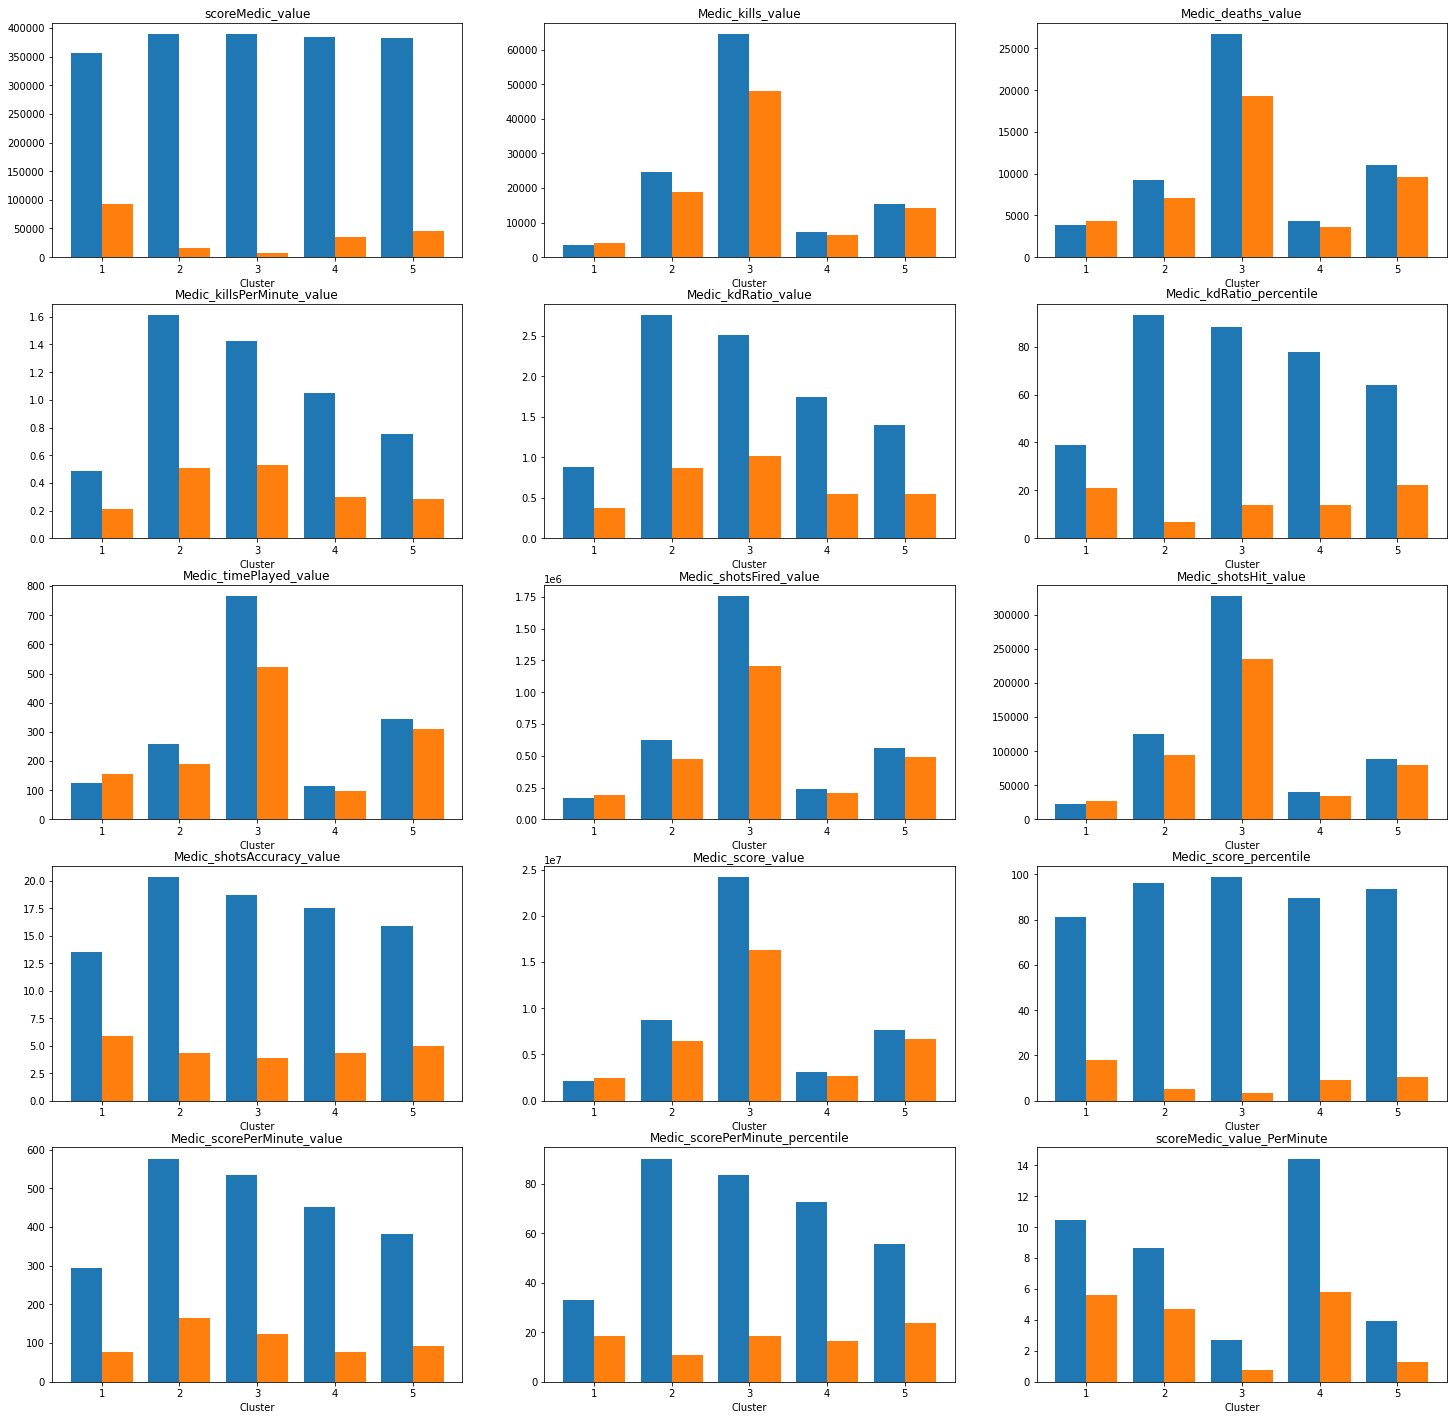

In [118]:
plot_cluster_stats(medic_features, 3, 5)

### Assault Features

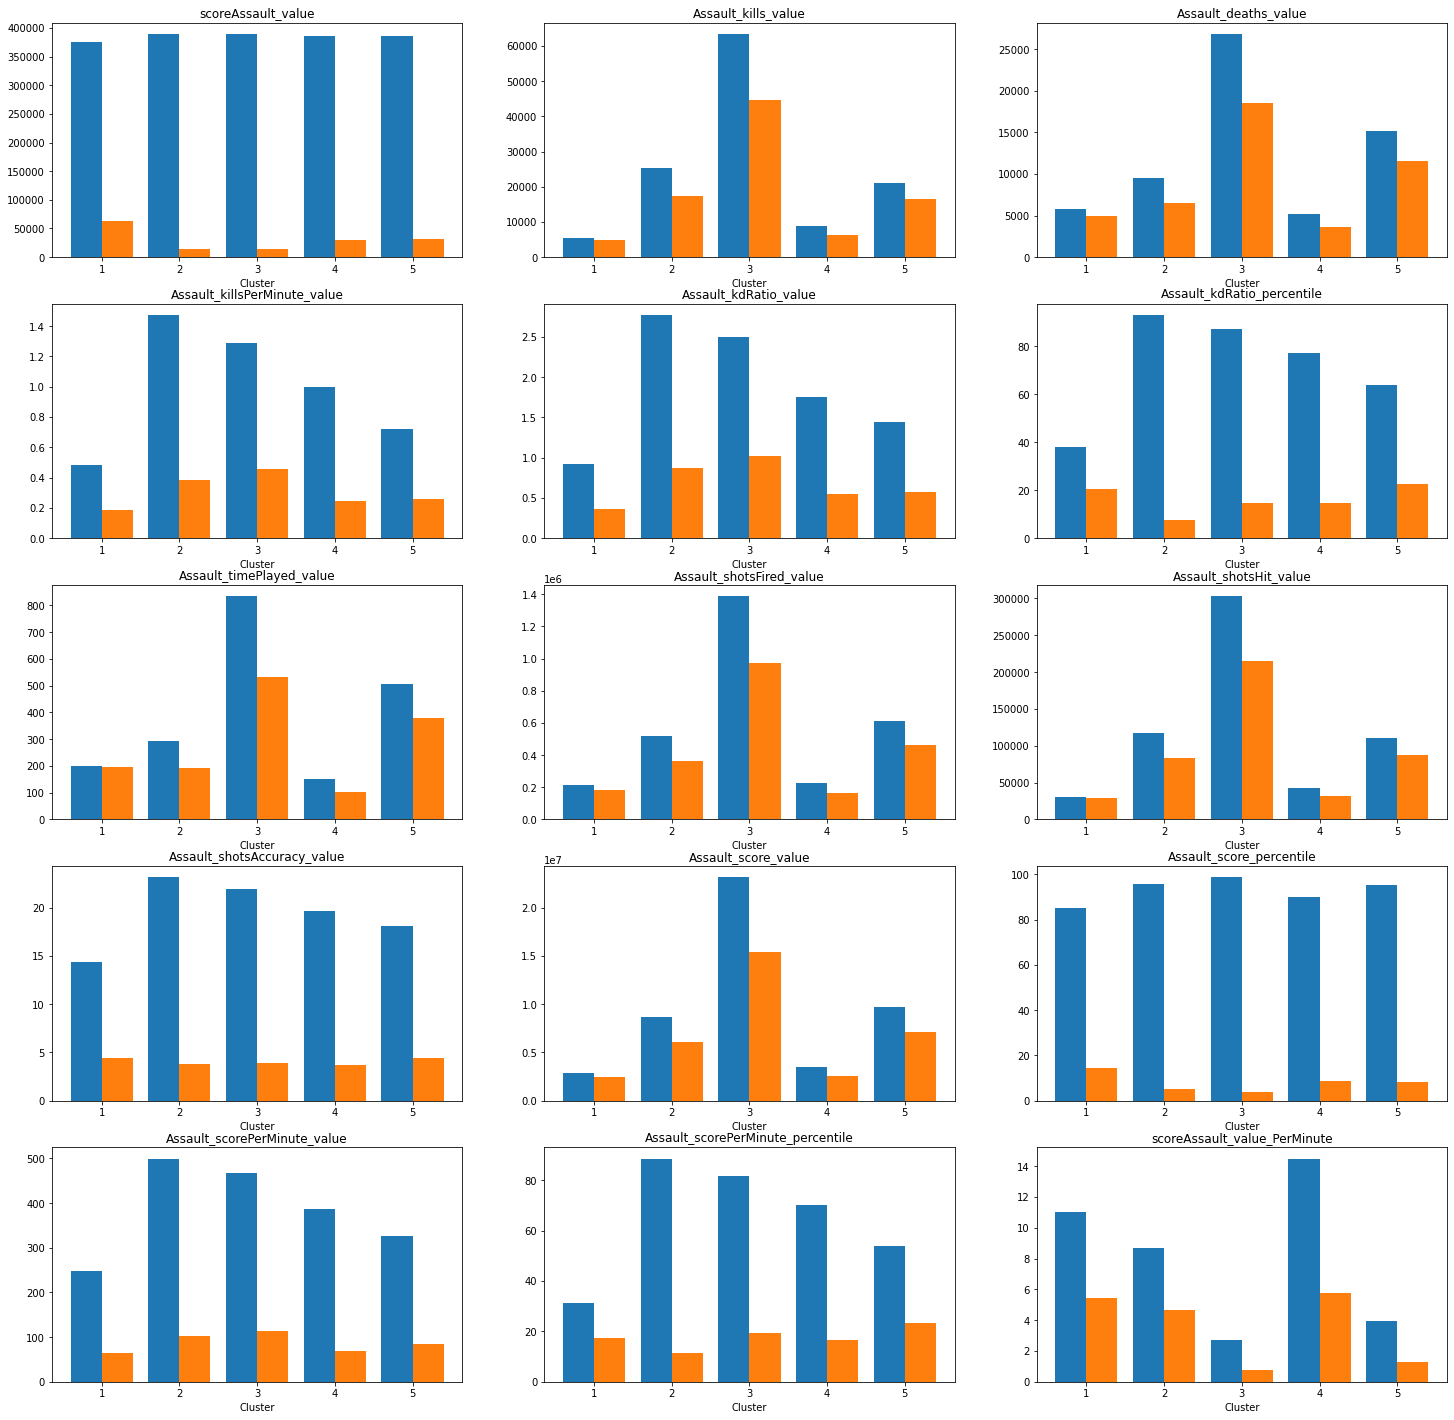

In [119]:
plot_cluster_stats(assault_features, 3, 5)

### Support Features

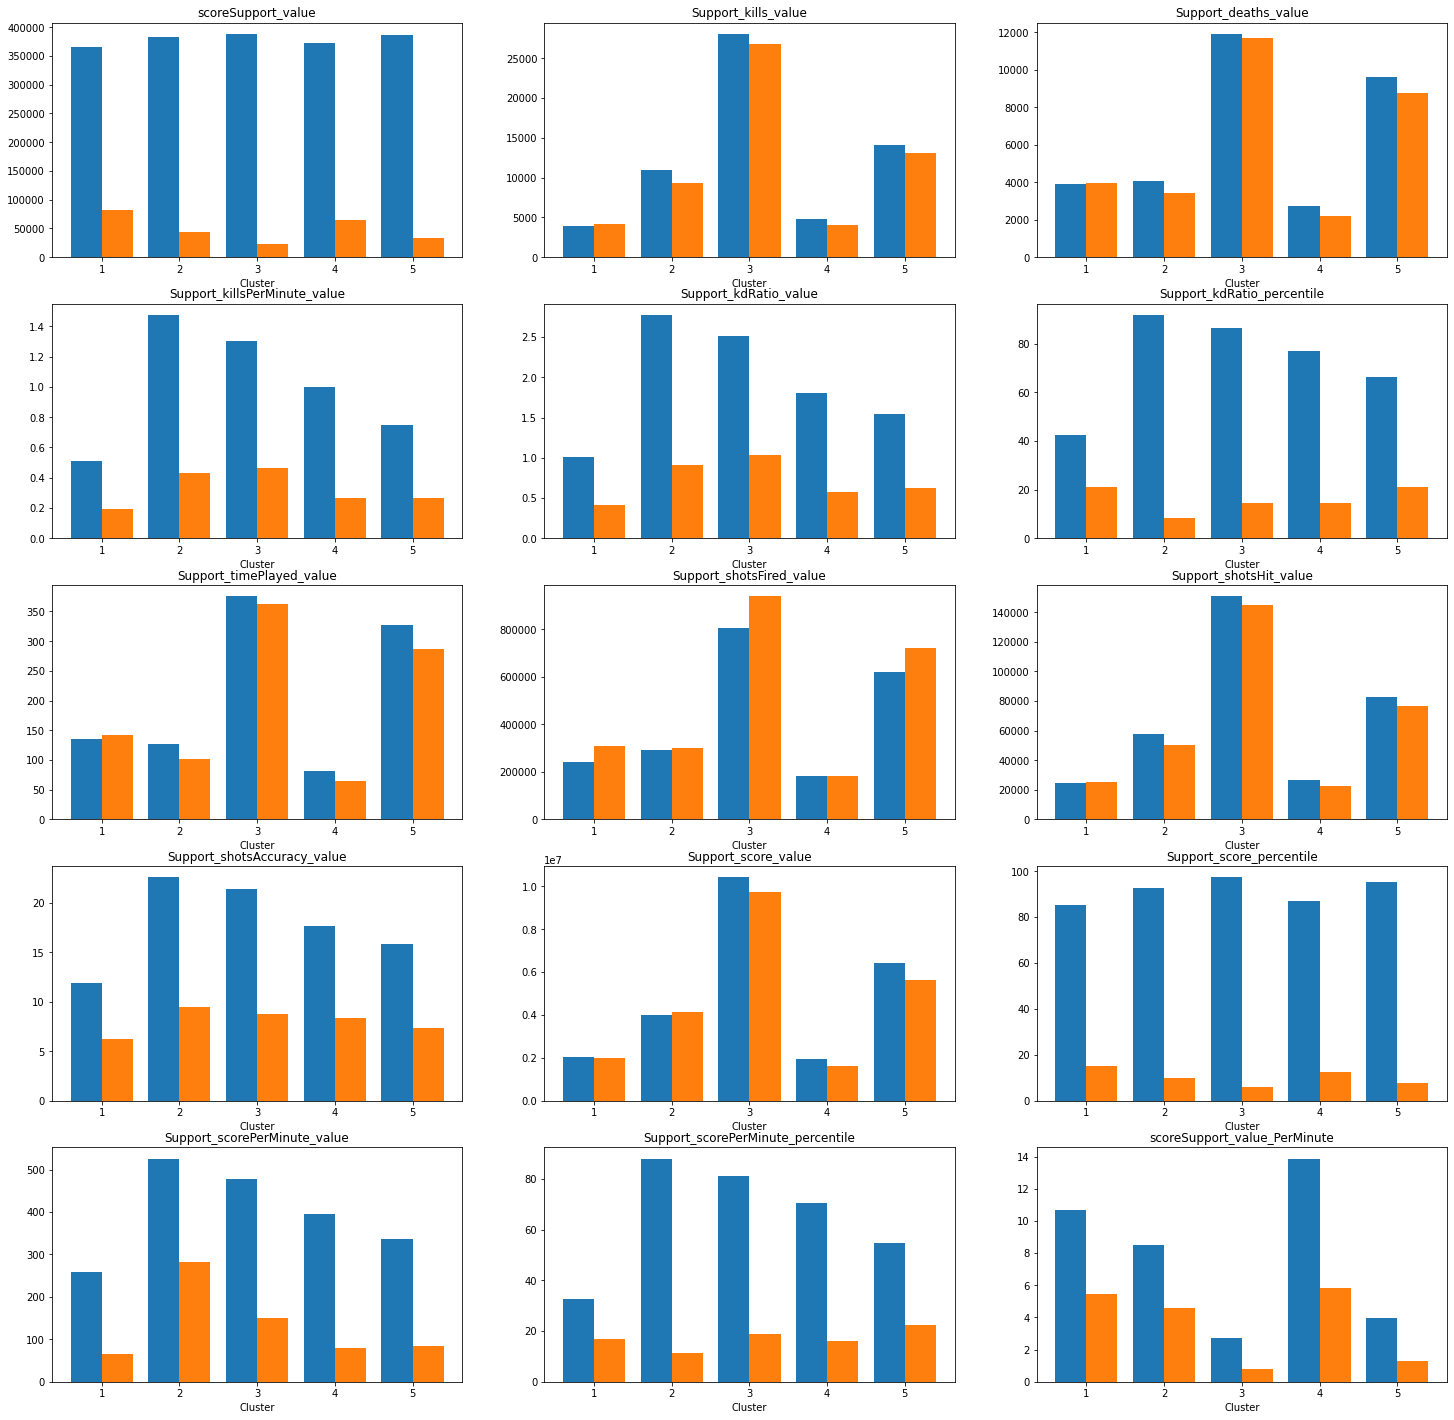

In [120]:
plot_cluster_stats(support_features, 3, 5)

### Recon Features

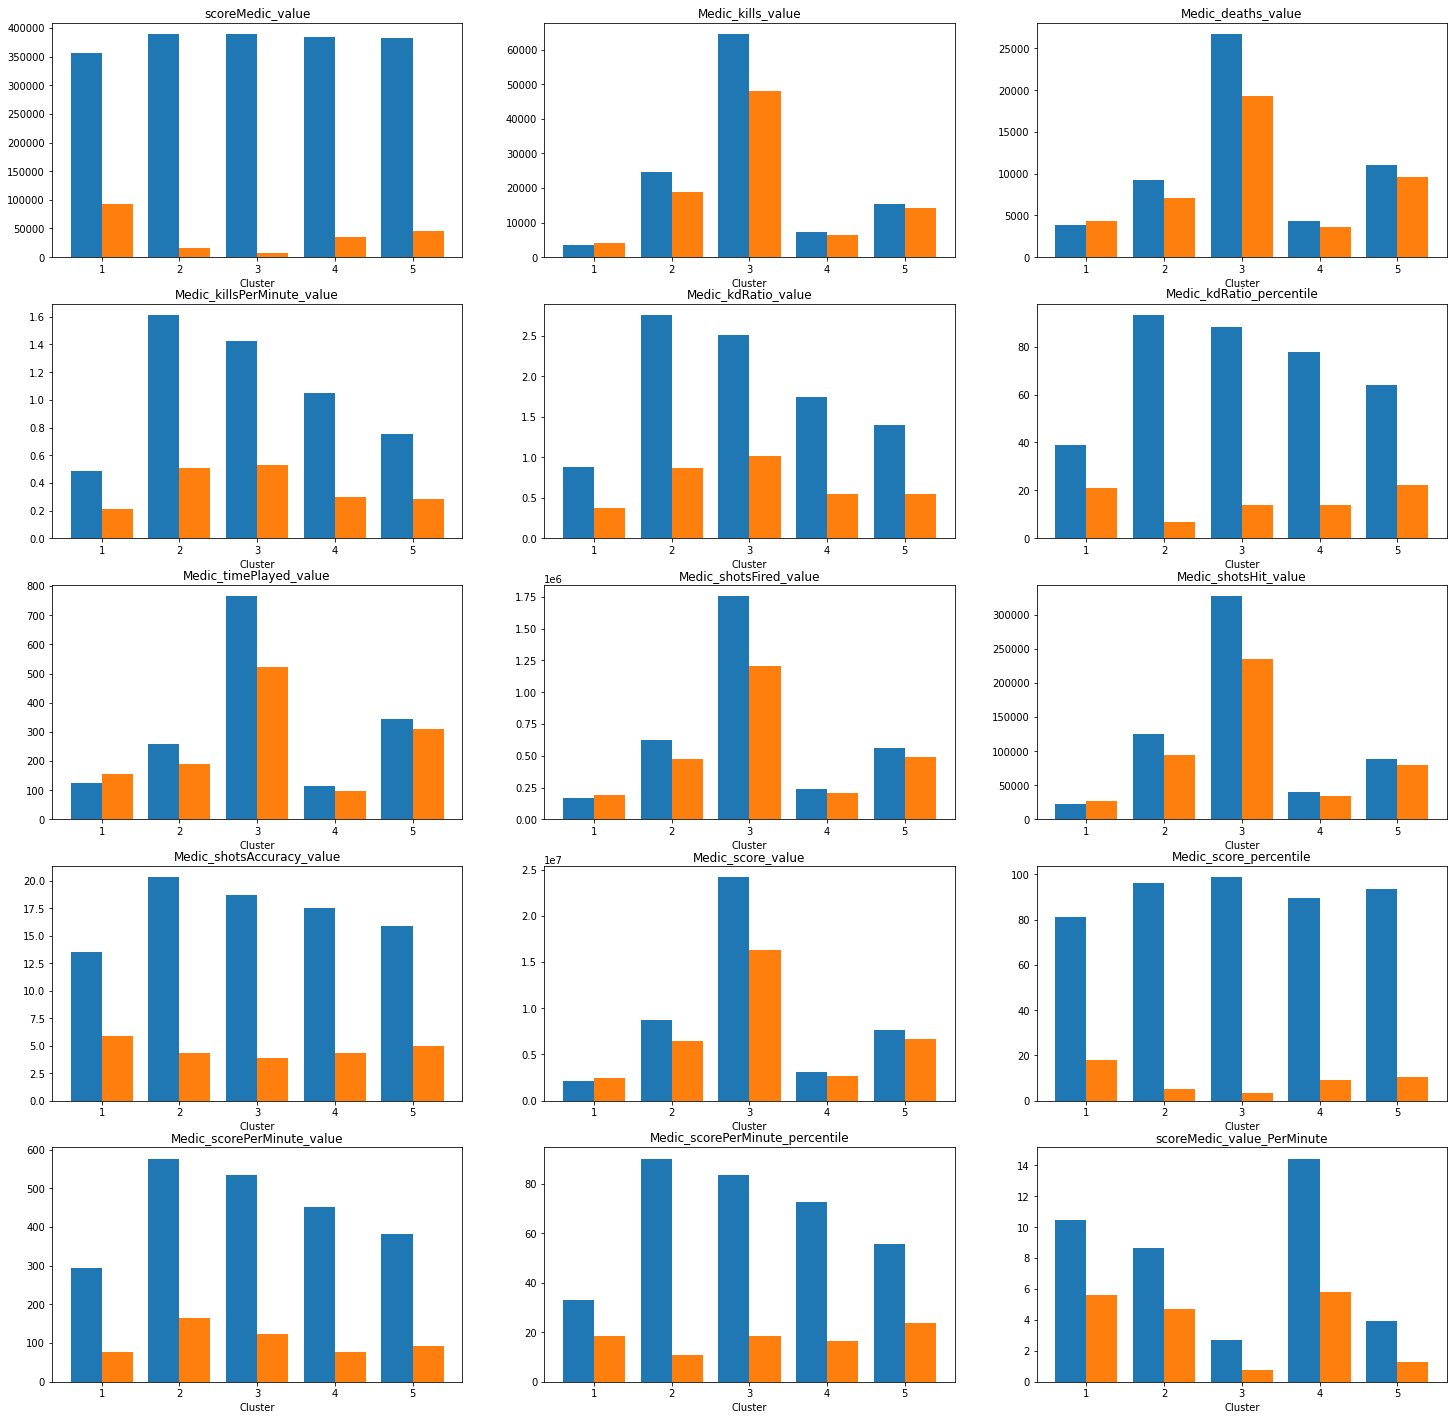

In [121]:
plot_cluster_stats(medic_features, 3, 5)

## Ground Vehicle Features

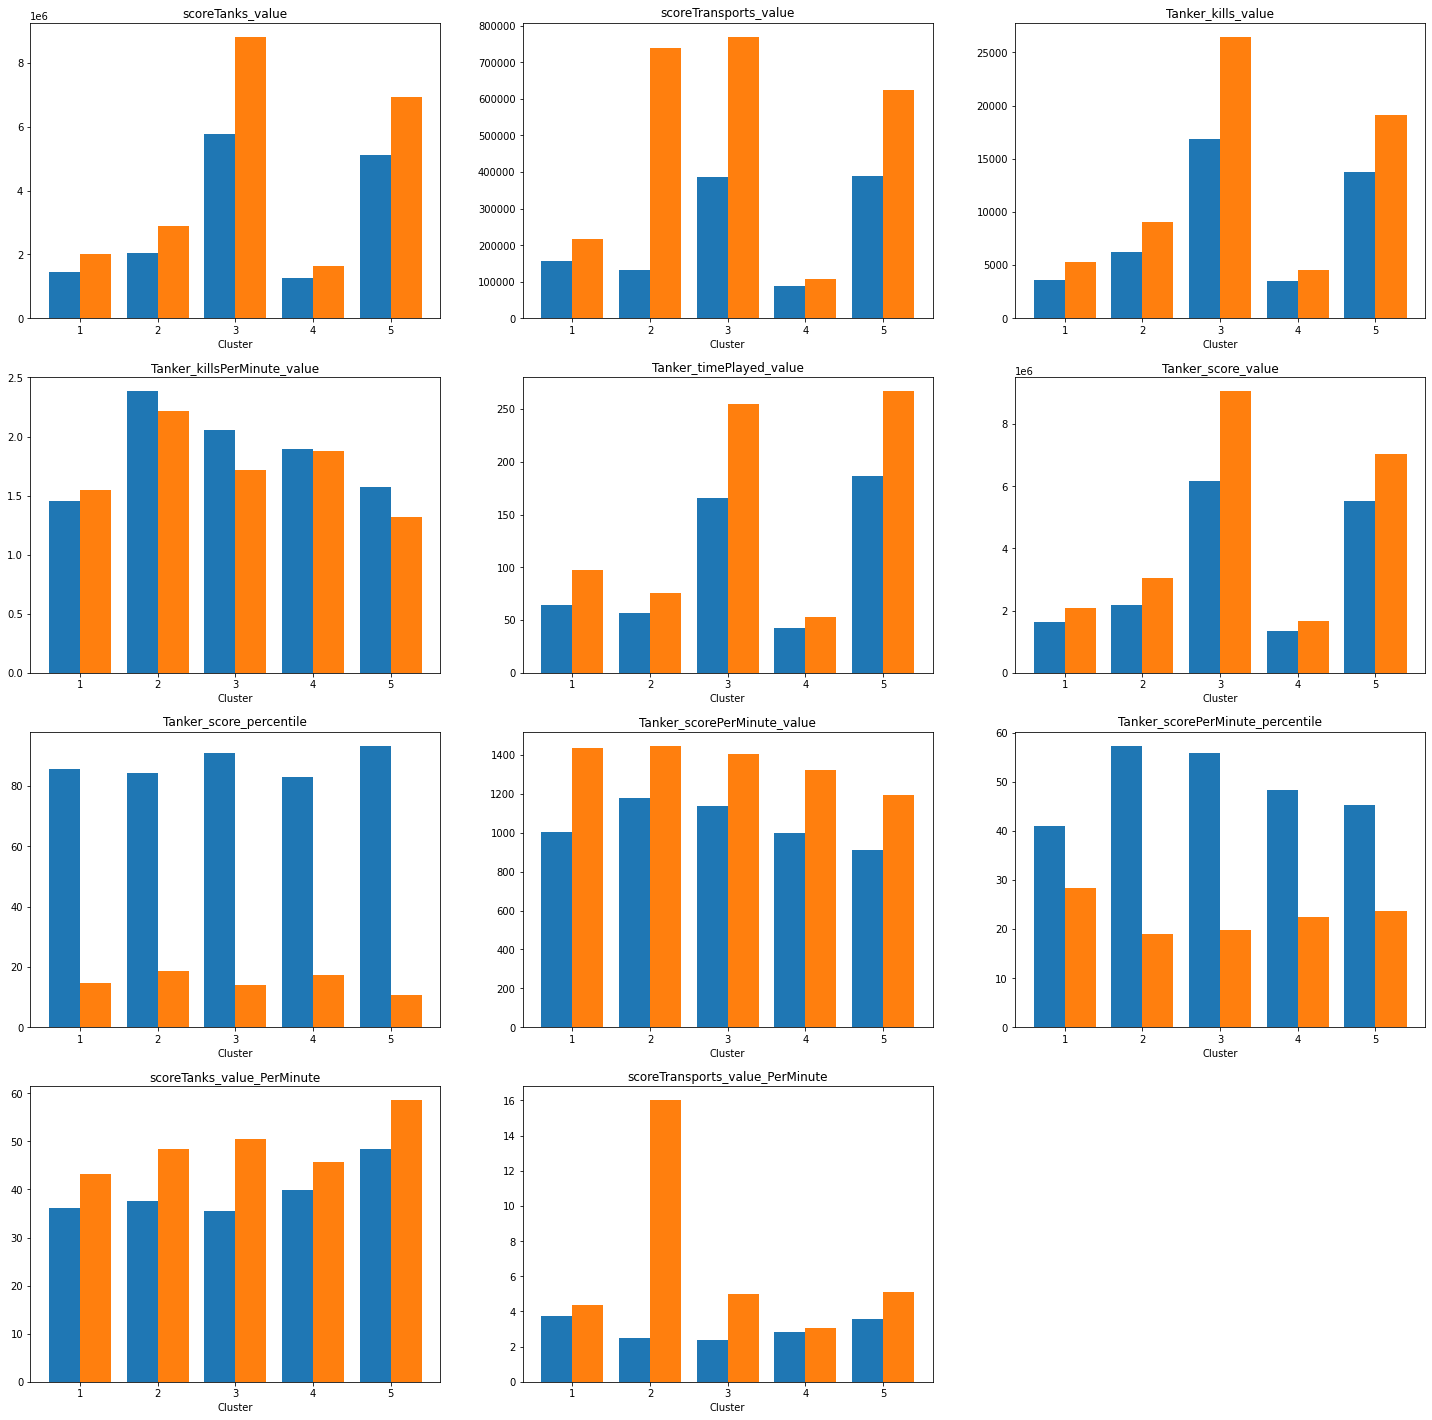

In [122]:
plot_cluster_stats(ground_vehicle_features, 3, 4)

### Plane Features

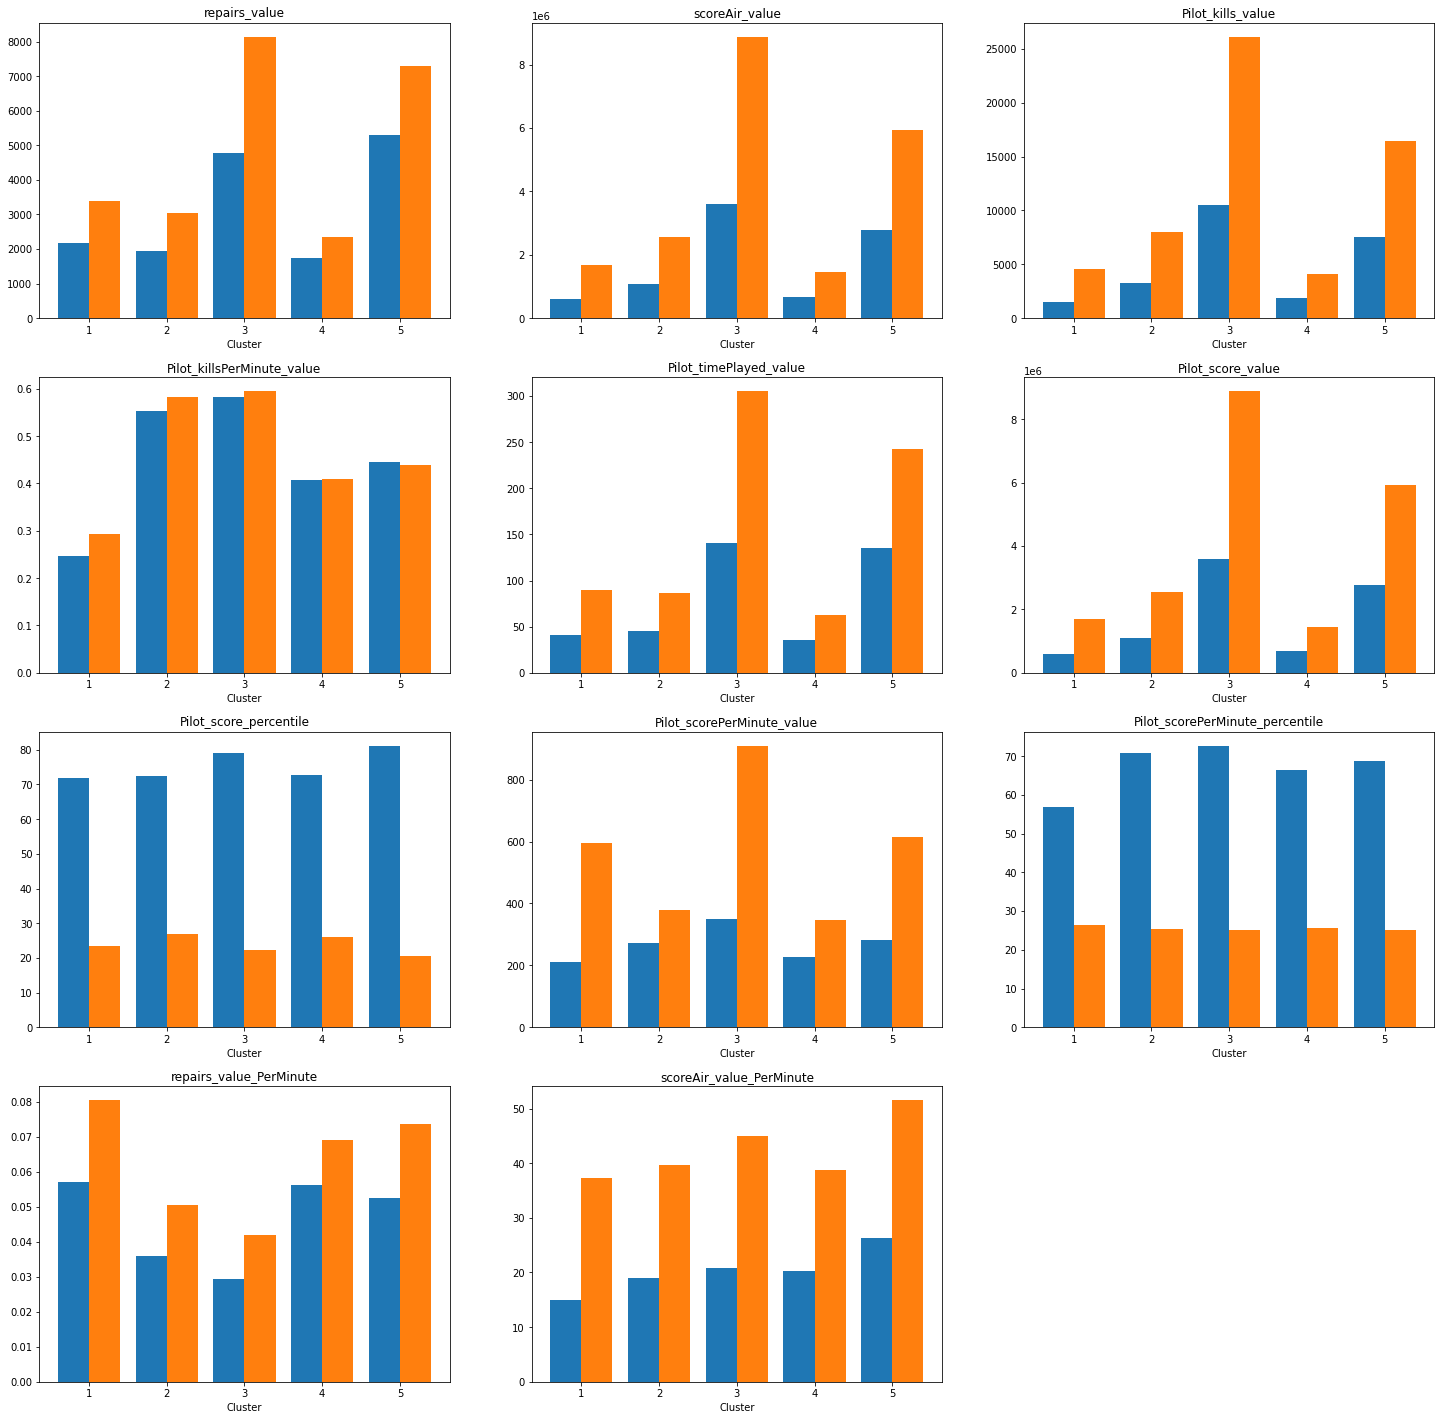

In [123]:
plot_cluster_stats(plane_features, 3, 4)

In [124]:
df['clusters'] = kmeans.labels_
df_cluster_summary = df.groupby('clusters').agg(['mean', 'std'])
df_cluster_summary

C:\Users\Patrick\AppData\Local\Temp\ipykernel_32412\1938406920.py:2: FutureWarning: ['platform'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_cluster_summary = df.groupby('clusters').agg(['mean', 'std'])


scorePerMinute_value             scorePerMinute_percentile  \
                         mean         std                      mean   
clusters                                                              
0                  263.418744   62.466934                 33.757727   
1                  527.454402  141.696629                 91.520108   
2                  515.042168  784.251012                 85.813197   
3                  400.430208   62.906864                 73.502545   
4                  349.920777   80.346797                 59.207556   

                    kdRatio_value           kdRatio_percentile             \
                std          mean       std               mean        std   
clusters                                                                    
0         18.218600      1.278911  0.836215          49.504417  24.434120   
1          8.553265      3.098463  1.058134          93.069552   6.160834   
2         16.323727      2.890530  1.299068          88.790286  12.316394   
3         14.651618      2.091426  0.872969          80.715738  12.963380   
4         22.784008      2.015860  1.268574          73.479989  20.905365   

            kills_value                ... scoreDefensive_value_PerMinute  \
                   mean           std  ...                           mean   
clusters                               ...                                  
0          21062.327532  11045.426075  ...                      65.507803   
1          79067.222693  32072.968562  ...                     131.049403   
2         203167.971749  72939.153187  ...                     119.381863   
3          30448.308211  11986.180518  ...                     101.487987   
4          81593.697758  31692.036937  ...                      83.729416   

                    scoreObjective_value_PerMinute             \
                std                           mean        std   
clusters                                                        
0         27.631734                      86.652978  34.757690   
1         68.830762                     143.951767  61.858408   
2         39.144214                     150.268010  59.614818   
3         29.095814                     114.716981  43.437558   
4         33.149359                     112.248352  44.537100   

         scoreBonus_value_PerMinute            scoreSquad_value_PerMinute  \
                               mean        std                       mean   
clusters                                                                    
0                         41.463001  11.265787                  42.885570   
1                         82.292009  22.744039                  74.082517   
2                         79.559797  41.703382                  75.598692   
3                         60.198872  15.496945                  59.480034   
4                         54.758615  13.411780                  54.110243   

                    scoreAward_value_PerMinute             
                std                       mean        std  
clusters                                                   
0         17.930853                  75.922219  31.606317  
1         25.032879                  72.679810  25.707948  
2         22.989208                  49.938401  14.277295  
3         18.427148                  84.118639  31.920972  
4         20.525863                  61.147414  22.320334  

[5 rows x 318 columns]

In [125]:
df[medic_features+['clusters']].groupby('clusters').agg(['mean', 'std'])

scoreMedic_value               Medic_kills_value                \
                     mean           std              mean           std   
clusters                                                                  
0           355676.610759  93091.266245       3440.238265   4149.816534   
1           389024.193222  15425.000519      24509.733284  18817.694542   
2           389634.766641   6807.570785      64526.704721  48036.135579   
3           384950.879512  35127.474338       7322.639627   6363.800463   
4           382545.461678  45491.434310      15225.011027  14182.873038   

         Medic_deaths_value               Medic_killsPerMinute_value  \
                       mean           std                       mean   
clusters                                                               
0               3847.785865   4285.590253                   0.488097   
1               9226.866642   7038.848306                   1.611805   
2              26742.280573  19360.721961                   1.424914   
3               4292.922848   3667.839597                   1.048467   
4              10989.051880   9584.803024                   0.752604   

                   Medic_kdRatio_value            ... Medic_score_value  \
               std                mean       std  ...              mean   
clusters                                          ...                     
0         0.208537            0.880530  0.378465  ...      2.135024e+06   
1         0.506497            2.757278  0.865188  ...      8.712797e+06   
2         0.530250            2.514387  1.016688  ...      2.414370e+07   
3         0.296058            1.745654  0.549421  ...      3.130909e+06   
4         0.283386            1.394862  0.549026  ...      7.670441e+06   

                       Medic_score_percentile             \
                   std                   mean        std   
clusters                                                   
0         2.437363e+06              81.354087  17.923868   
1         6.406183e+06              96.110794   5.009446   
2         1.634639e+07              98.671672   3.397815   
3         2.657013e+06              89.777086   8.936810   
4         6.614581e+06              93.550791  10.614645   

         Medic_scorePerMinute_value              \
                               mean         std   
clusters                                          
0                        294.153294   78.252468   
1                        576.422779  164.432621   
2                        535.242390  124.472736   
3                        450.330941   77.319279   
4                        380.657069   92.604279   

         Medic_scorePerMinute_percentile             \
                                    mean        std   
clusters                                              
0                              33.017420  18.664423   
1                              90.070326  10.751649   
2                              83.436958  18.636075   
3                              72.722155  16.276122   
4                              55.422799  23.918631   

         scoreMedic_value_PerMinute            
                               mean       std  
clusters                                       
0                         10.441364  5.631949  
1                          8.678524  4.691255  
2                          2.709019  0.780685  
3                         14.425053  5.805710  
4                          3.917882  1.307561  

[5 rows x 30 columns]

In [126]:
df.groupby(['clusters', 'platform']).count()['scoreMedic_value']

clusters  platform
0         origin      3251
          psn         3121
          xbl         1212
1         origin      2426
          psn         2051
          xbl          952
2         origin       803
          psn         1233
          xbl          548
3         origin      4804
          psn         3529
          xbl         1751
4         origin      1809
          psn         2666
          xbl         1057
Name: scoreMedic_value, dtype: int64

In [127]:
df_cluster_summary['kdRatio_value']['mean']

clusters
0    1.278911
1    3.098463
2    2.890530
3    2.091426
4    2.015860
Name: mean, dtype: float64